In [4]:
import os
from zodiax.experimental import deserialise
import amigo
from amgio import build_model
from io_funcs import niriss_parang
from amgio import plotting
import jax
from jax import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps

import ehtplot
import scienceplots

plt.style.use(['science', 'bright', 'no-latex'])

# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 8

inferno = colormaps["inferno"]
viridis = colormaps["viridis"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
viridis.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

jax.config.update("jax_enable_x64", True)

In [5]:
final_params_dir = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/io_outputs/"
model_cache = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/"
data_cache = "/Users/mcha5804/JWST/ERS1373/calslope_18/"

# Bind file path, type and exposure type
file_fn = lambda **kwargs: amigo.files.get_files(
    data_cache,
    "calslope",
    EXP_TYPE="NIS_AMI",
    FILTER=["F480M", "F430M", "F380M"],
    **kwargs
)

all_files = file_fn()  # loading io and calibrator files

# selecting the IO files out from the calibrator
files = [file for file in all_files if file[0].header["TARGPROP"] == "IO"]

In [6]:
model, exposures = build_model.build_io_model(files, model_cache)
pscale = model.psf_pixel_scale / model.oversample

In [11]:
fit_params = [
    "positions",
    "fluxes",
    "log_distribution",
    "source_spectrum.coefficients",
]

distributions_dict = {}
custom_key = lambda s: (s.split('_')[0], float(s.split('_')[1]))  # sorting function
subdirectories = sorted([subdir for subdir in os.listdir(final_params_dir)], key=custom_key)

for subdir in subdirectories:
    # updating model
    final_params = deserialise(final_params_dir + subdir + "/final_params.zdx")
    this_model = model.set(fit_params, final_params)

    # saving distribution
    distributions_dict[subdir] = np.array([this_model.distribution(exp) for exp in exposures])


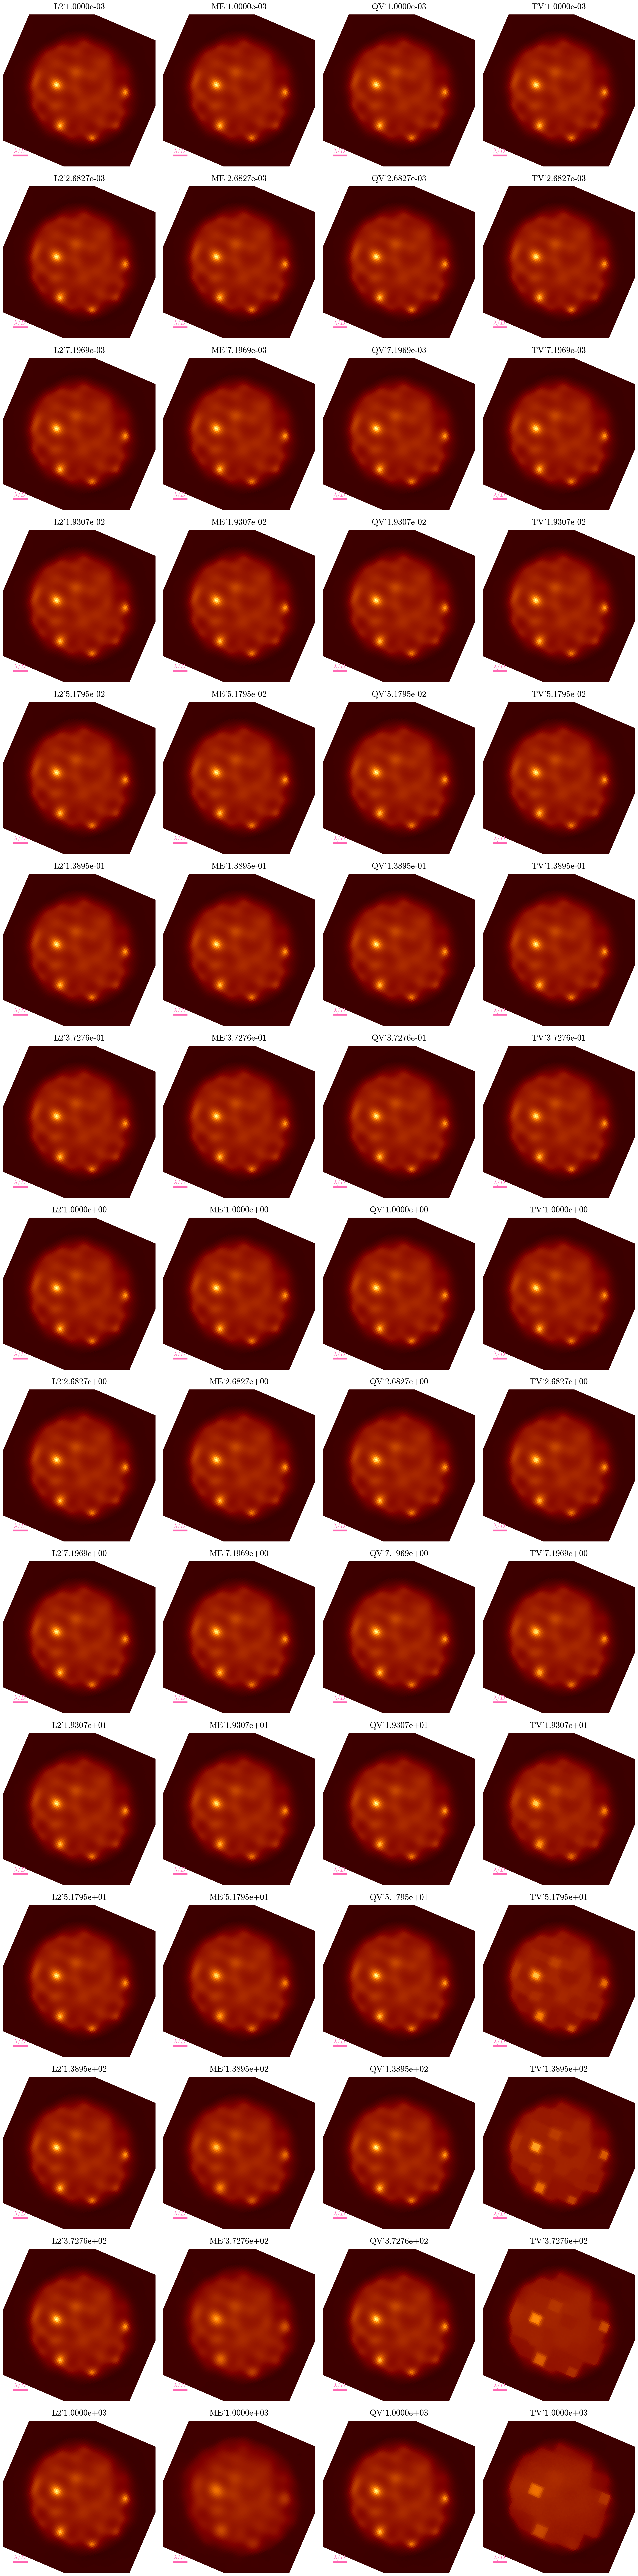

In [16]:
vmax = max([np.max(distribution) for distribution in distributions_dict.values()])


fig, axes = plt.subplots(15, 4, figsize=(10, 40), sharex=True, sharey=True)
# fig.patch.set_facecolor('black')

for ax, key, dists in zip(axes.T.flatten(), distributions_dict.keys(), distributions_dict.values()):
    
    roll_angle = niriss_parang(files[0][1].header)

    ax.axis("off")
    plotting.plot_io(
        ax,
        dists[0],
        roll_angle_degrees=roll_angle,
        pixel_scale=pscale,
        model=model,
        vmax=vmax
    )
    # ax.imshow(dists[0], cmap="afmhot_10u", origin="lower", norm=mpl.colors.PowerNorm(0.5))
    ax.set(
        title=key,
    )
plt.tight_layout()
plt.show()

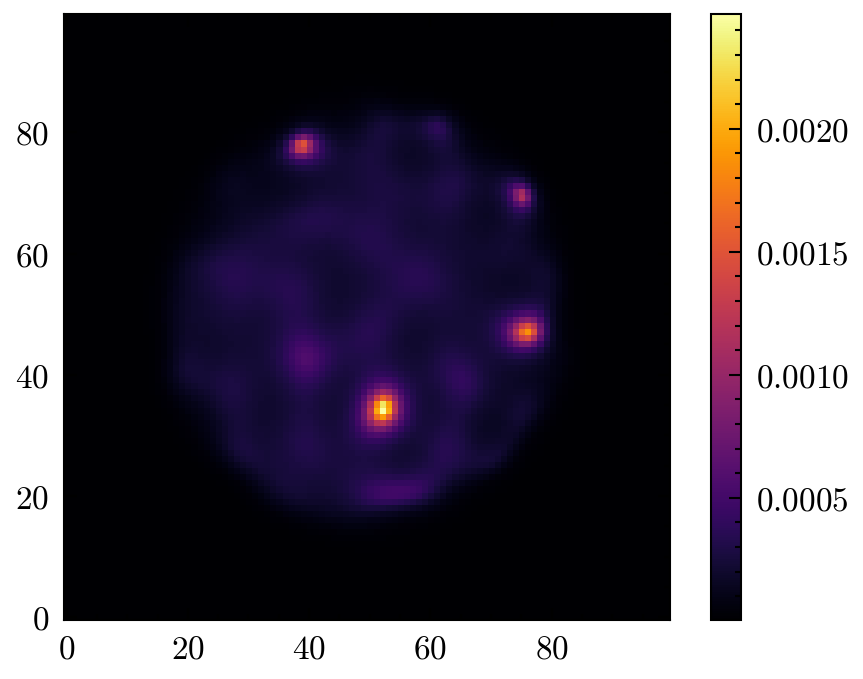

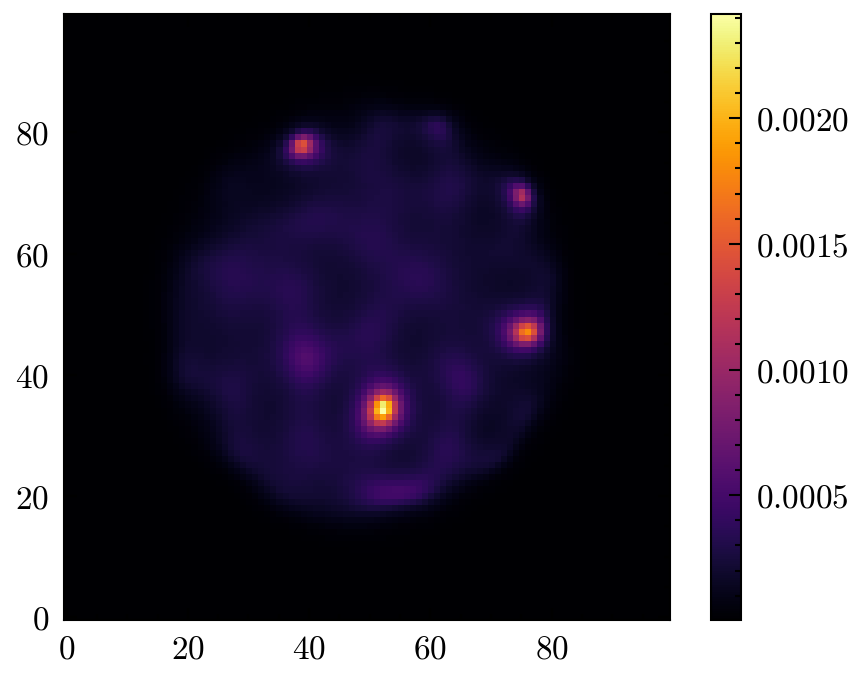

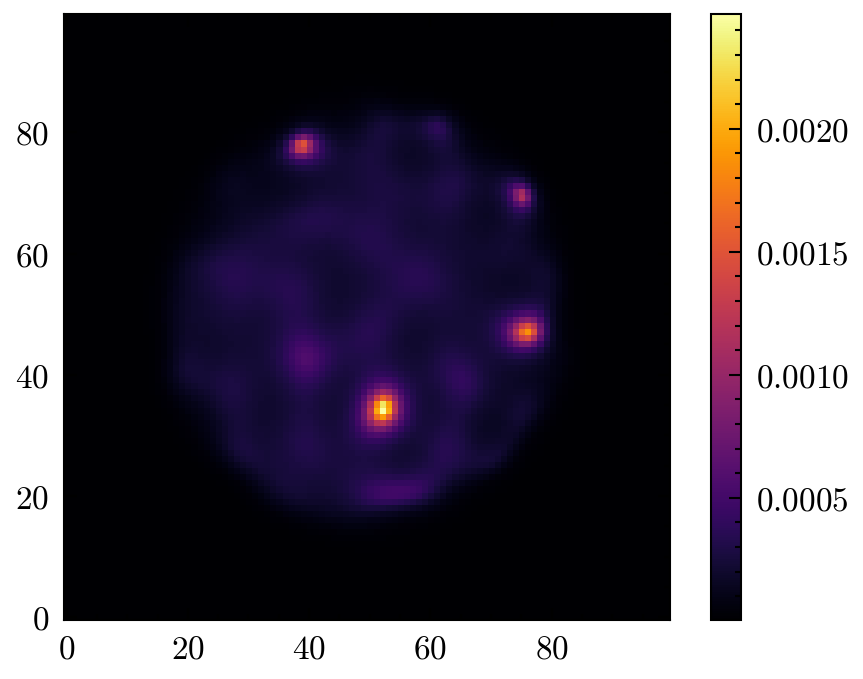

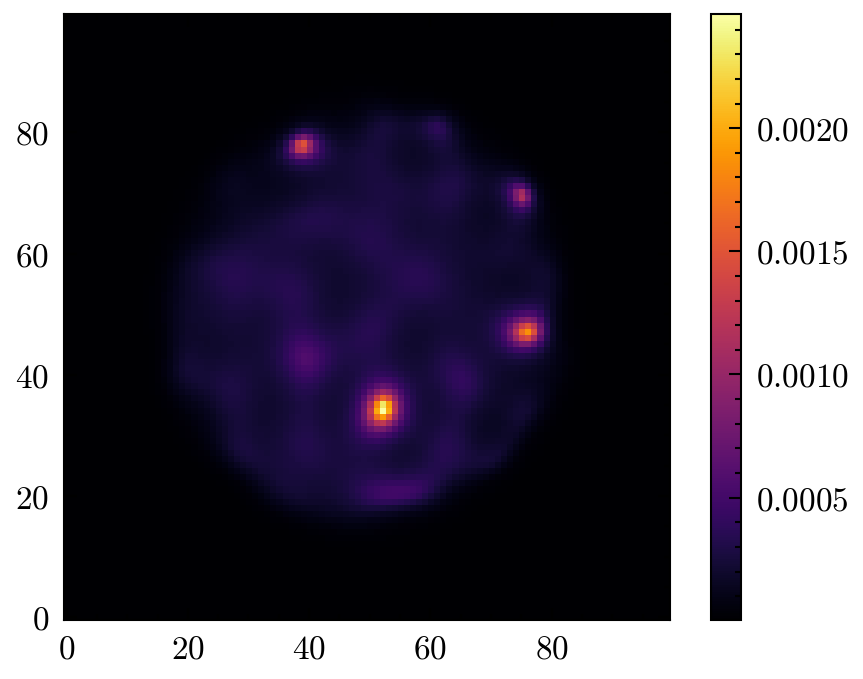

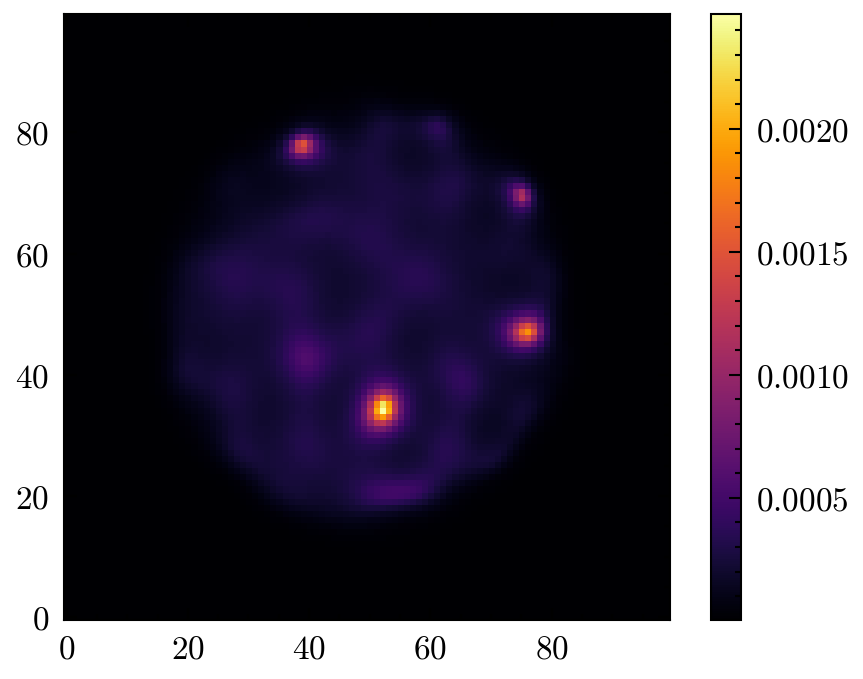

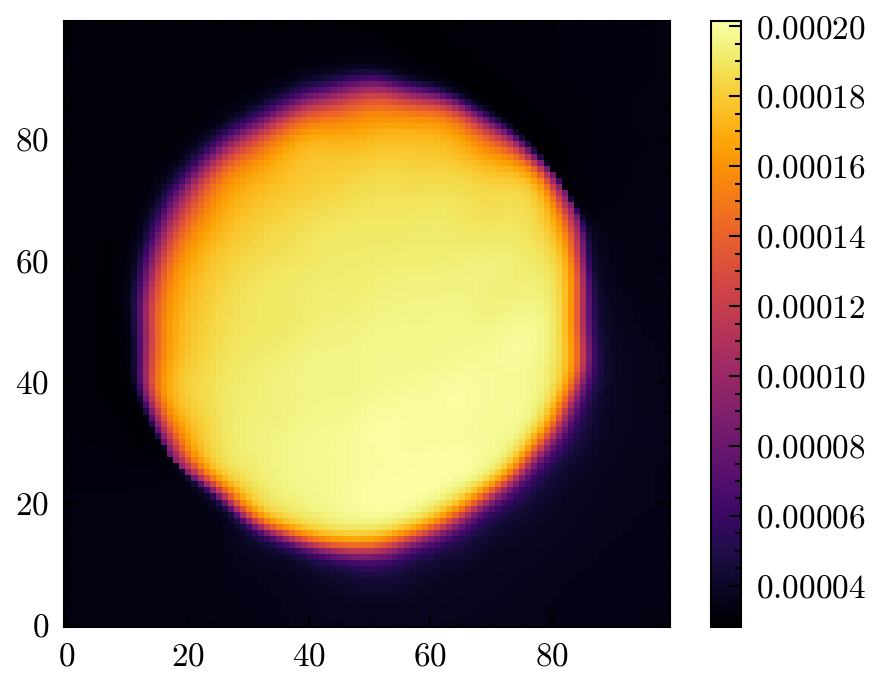

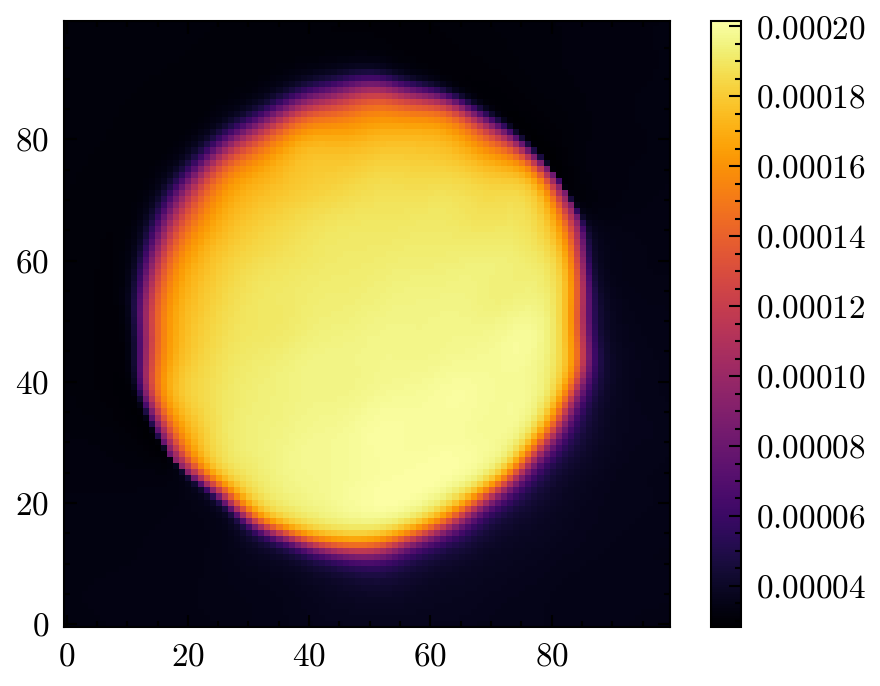

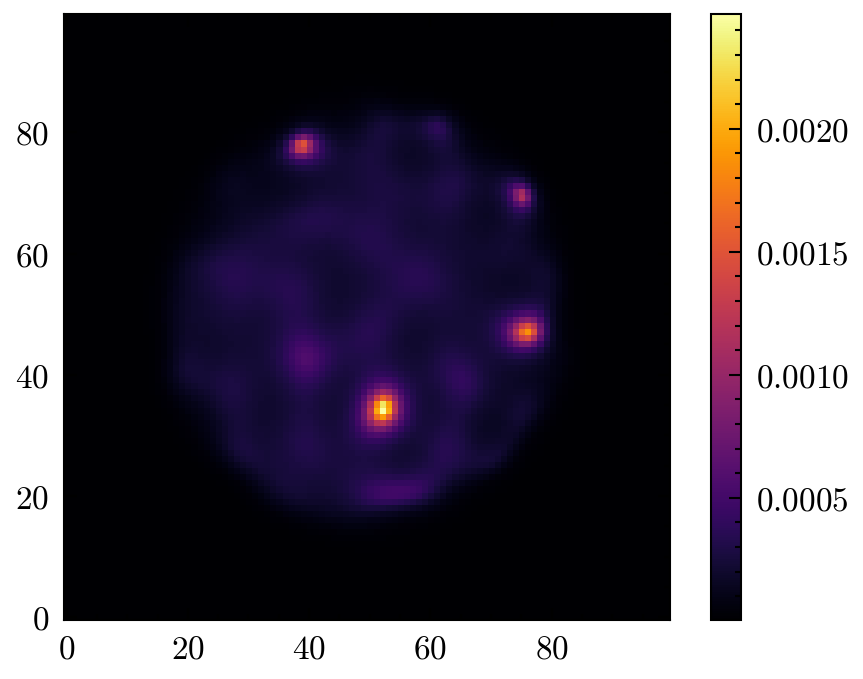

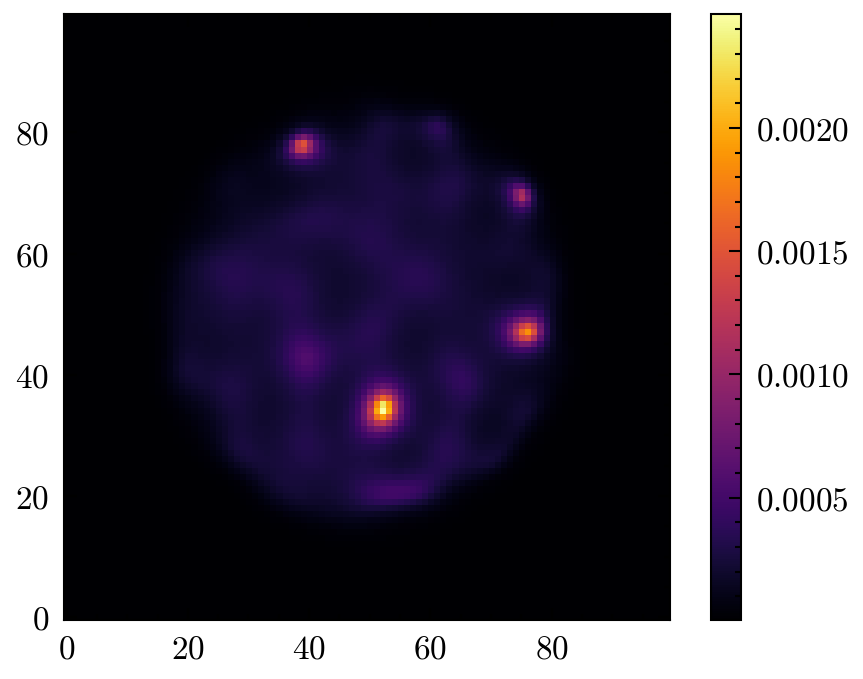

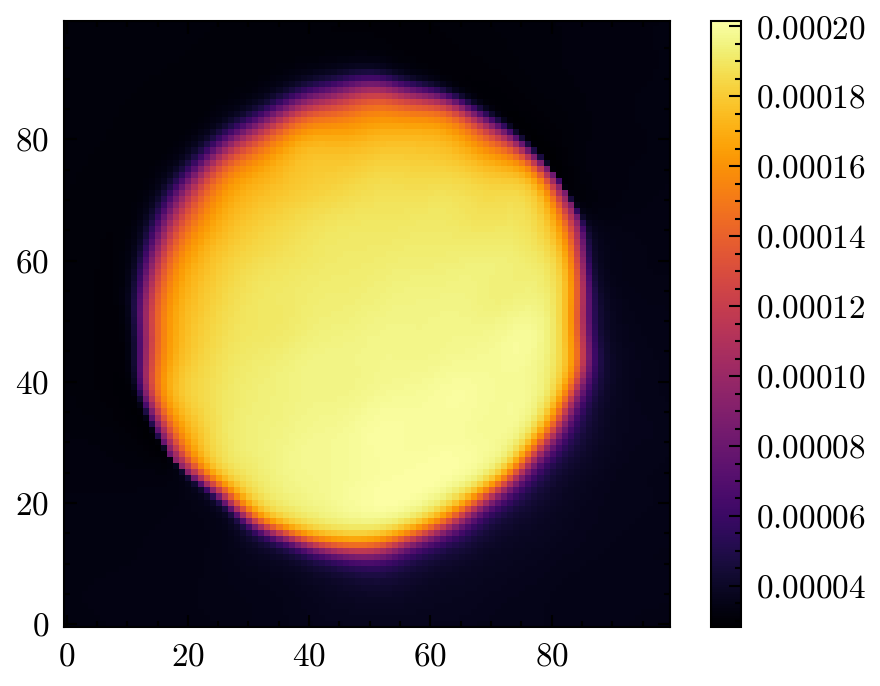

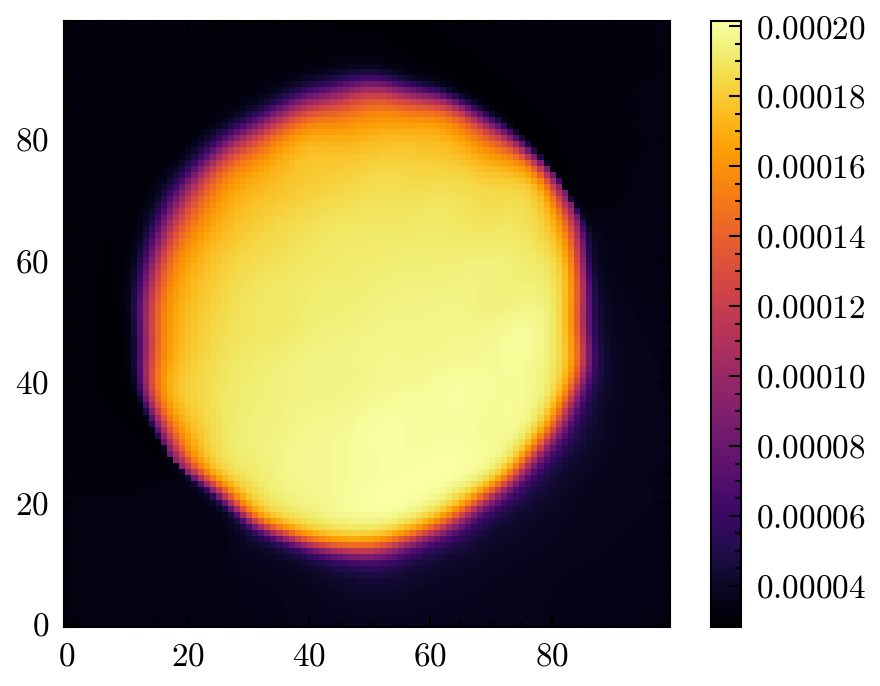

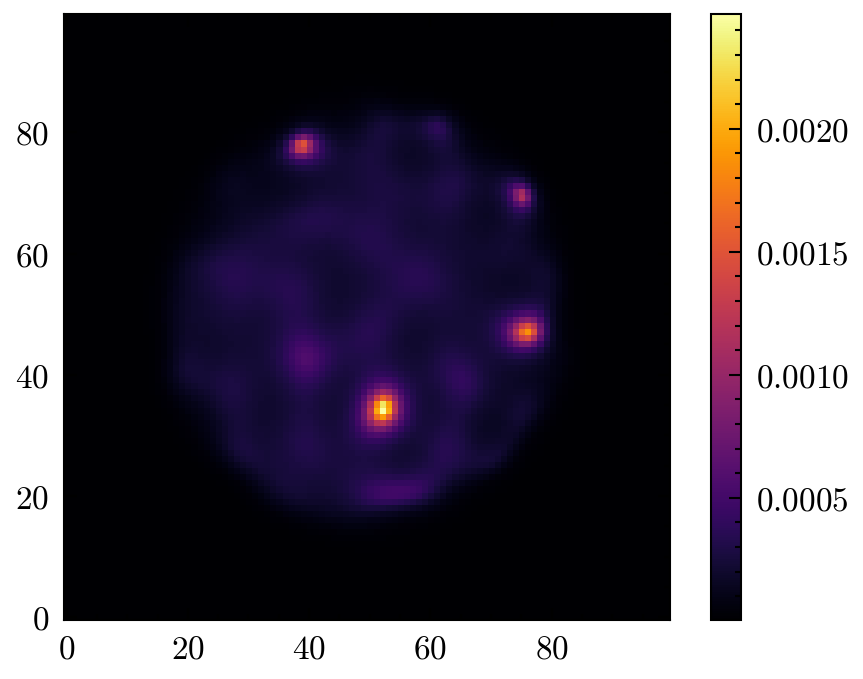

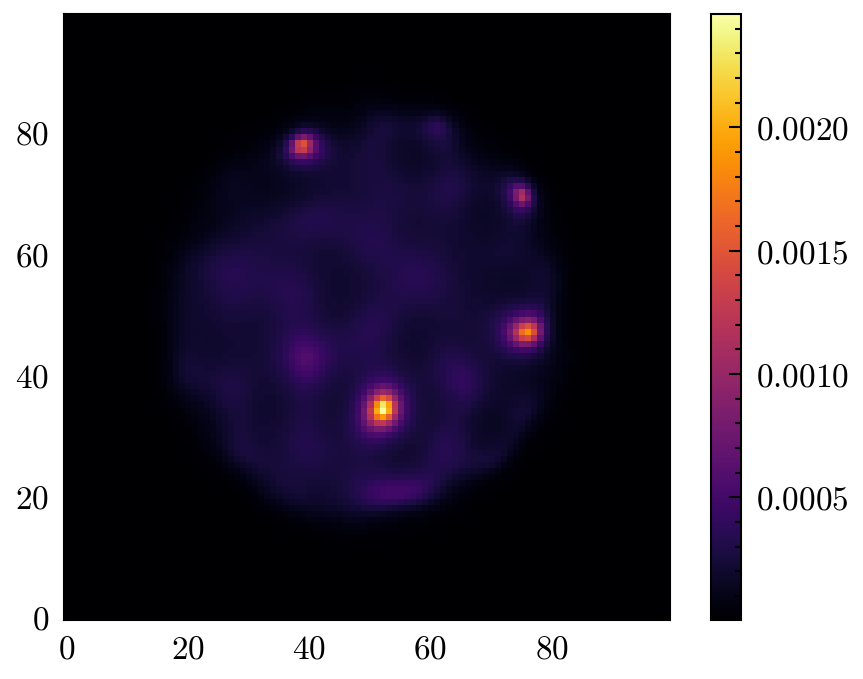

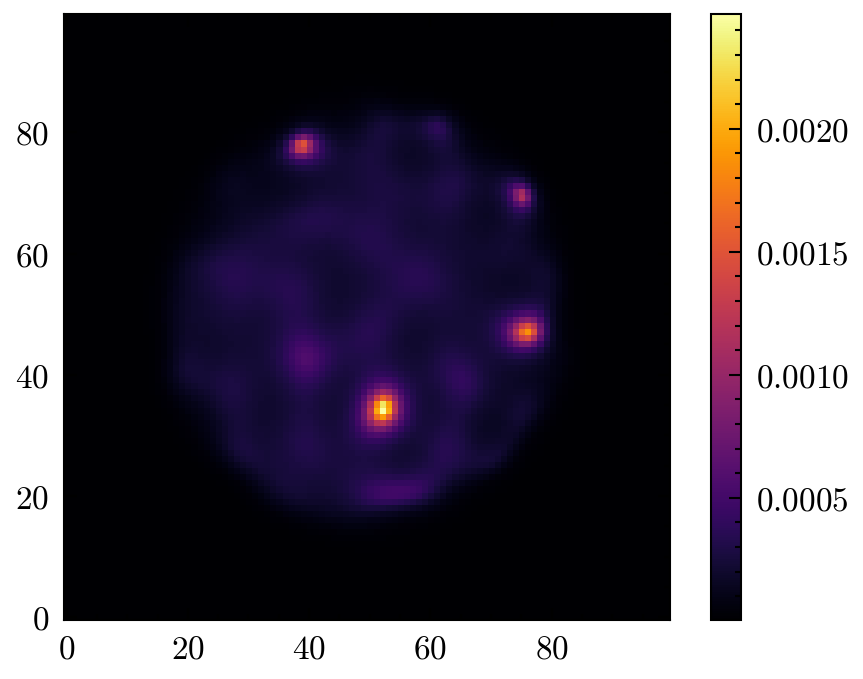

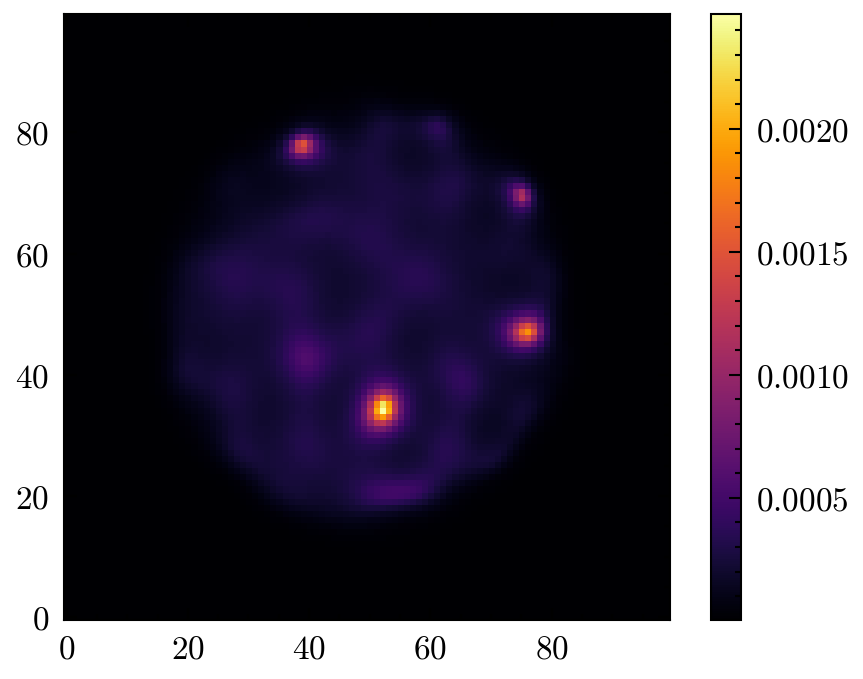

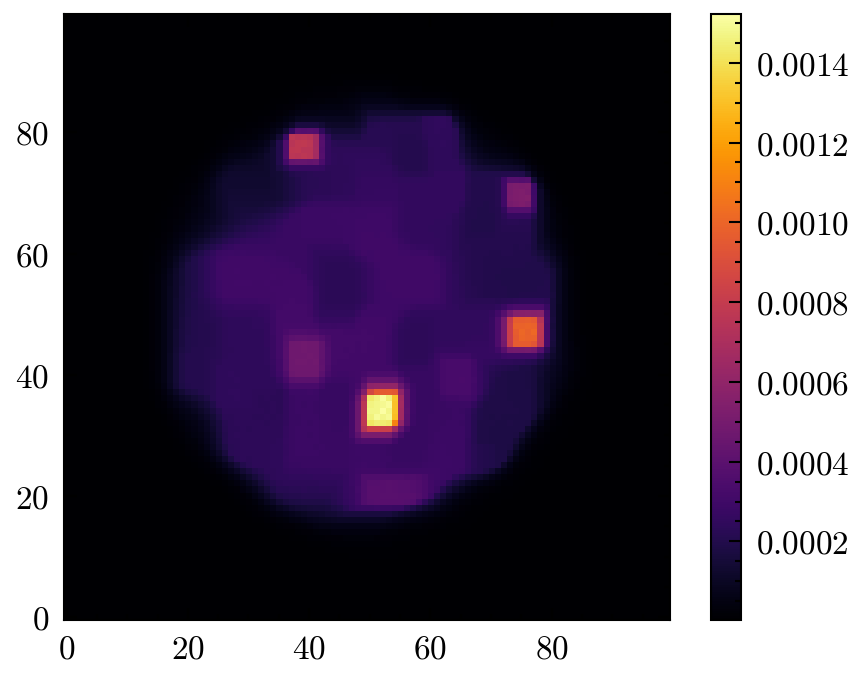

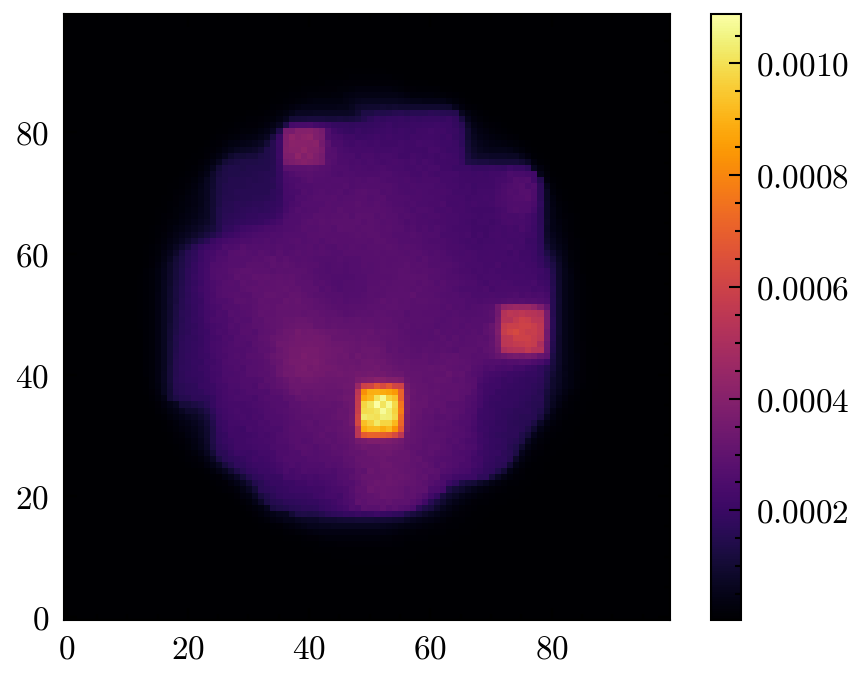

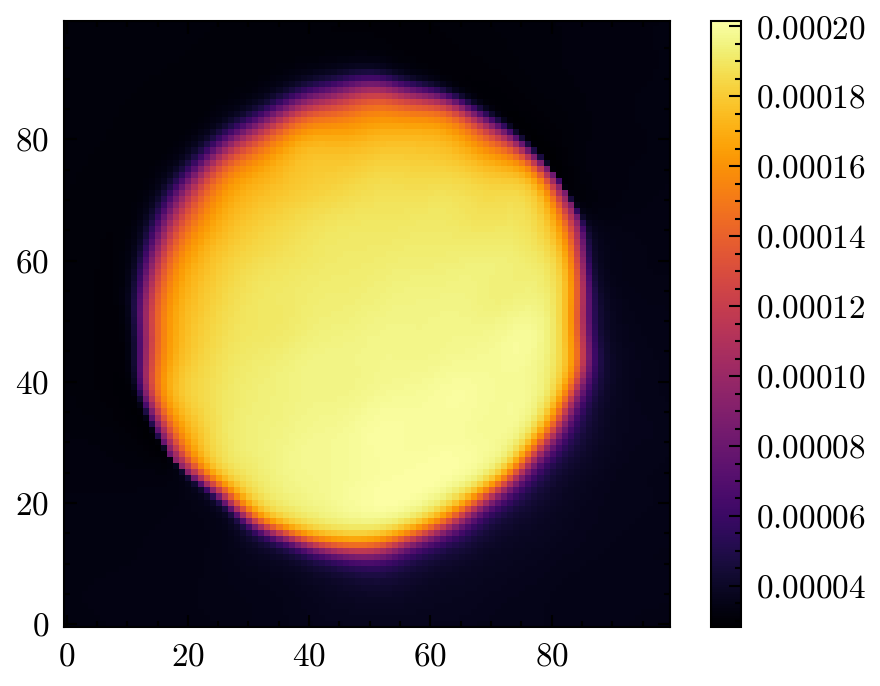

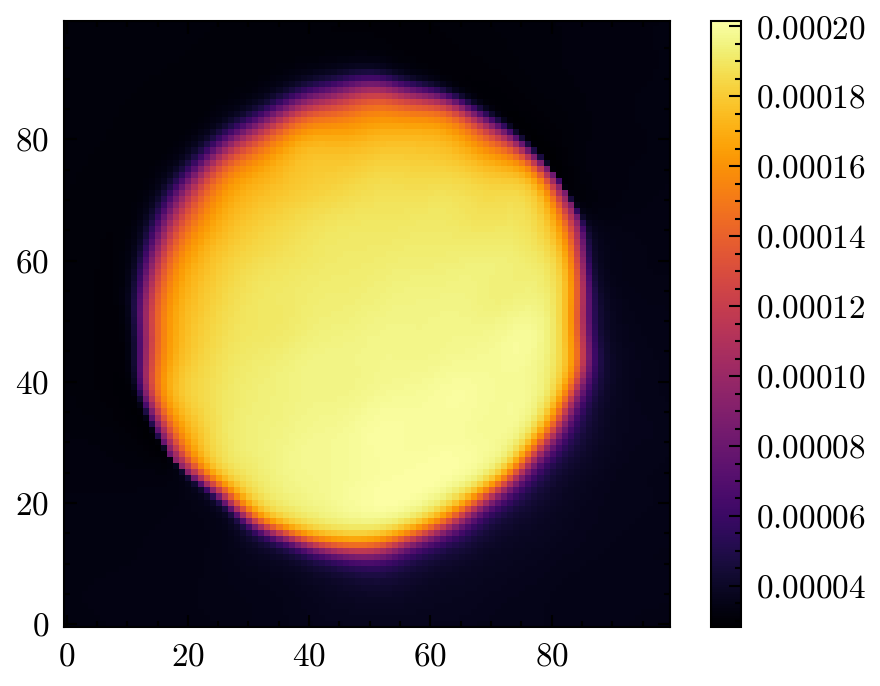

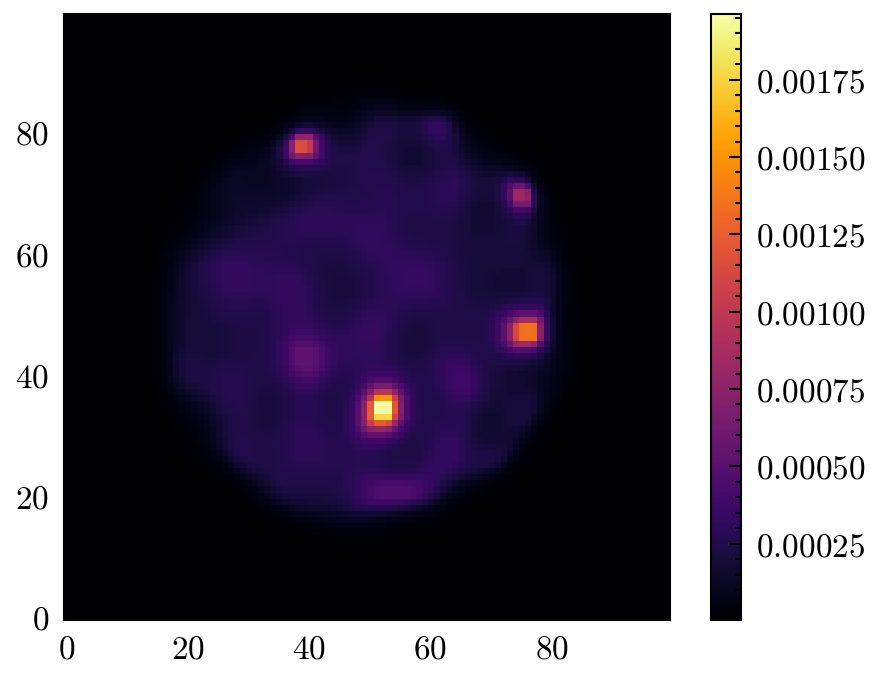

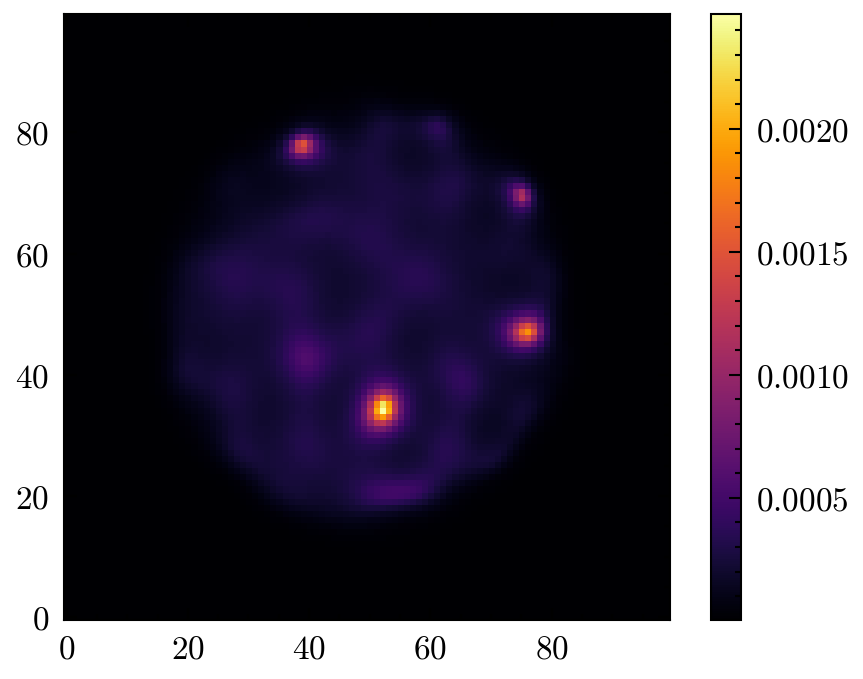

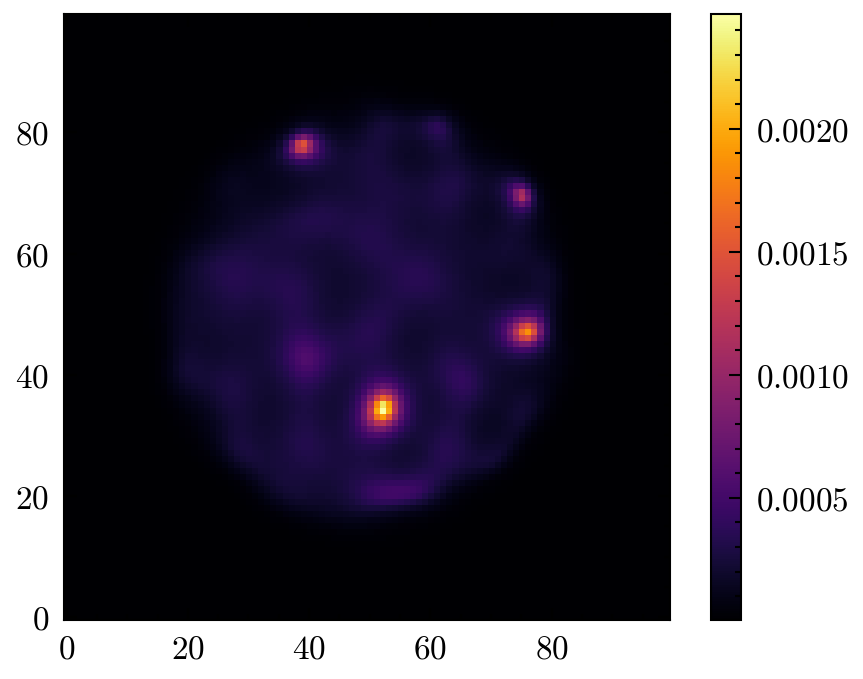

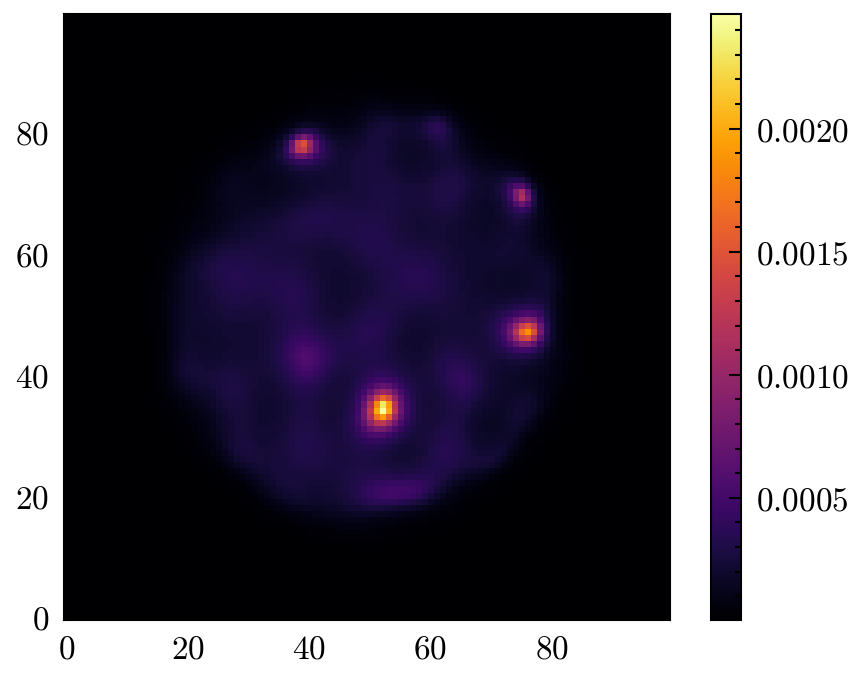

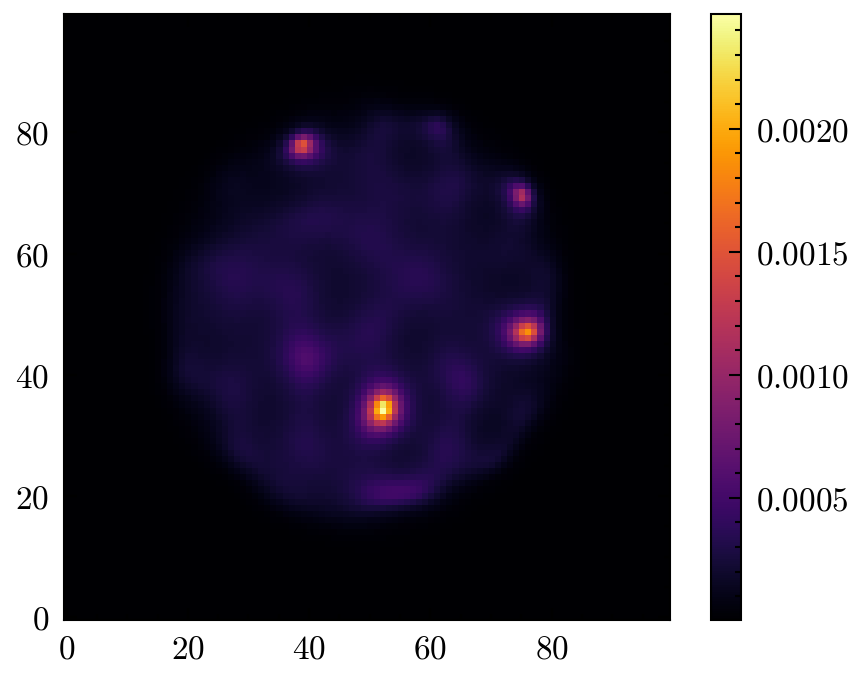

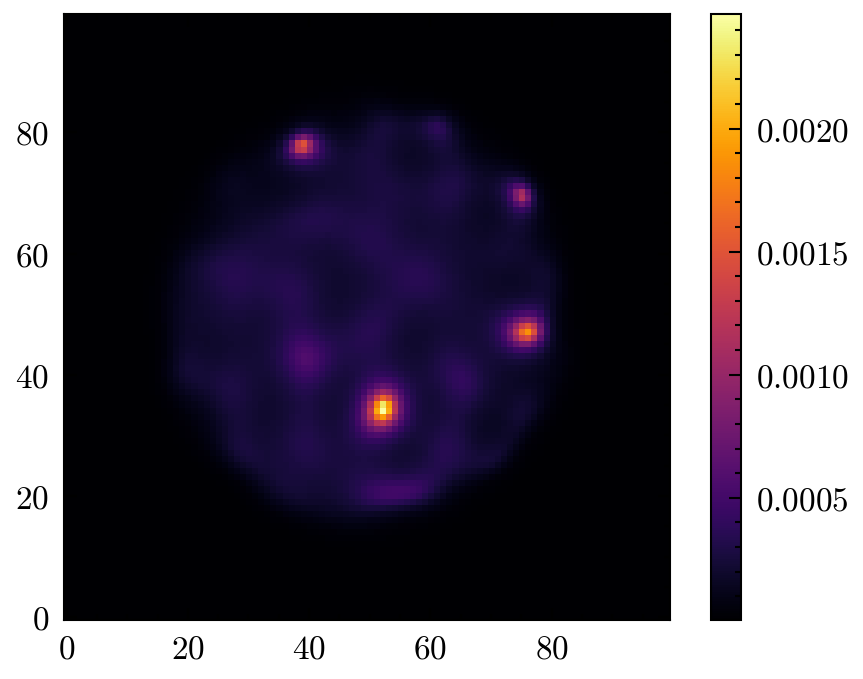

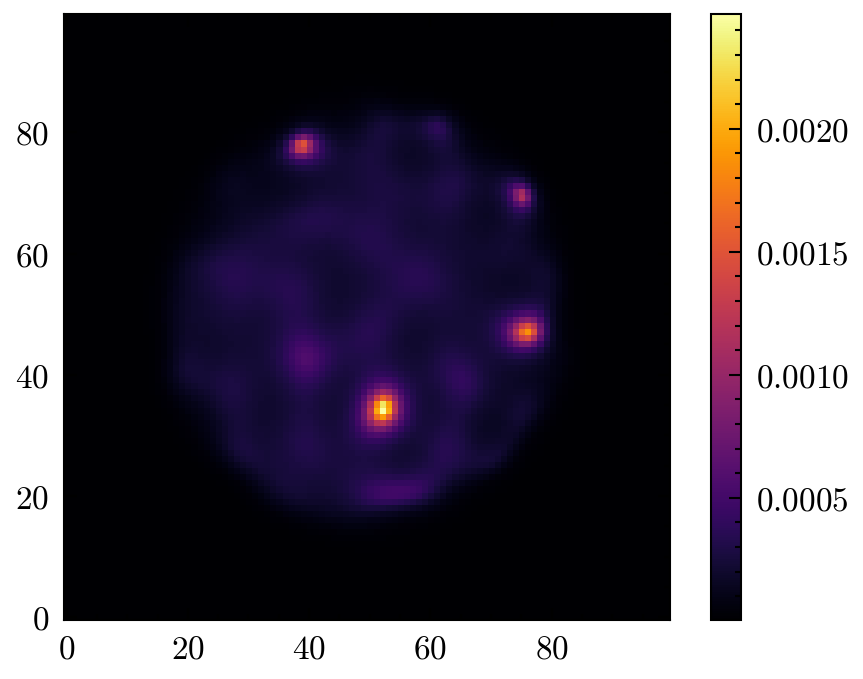

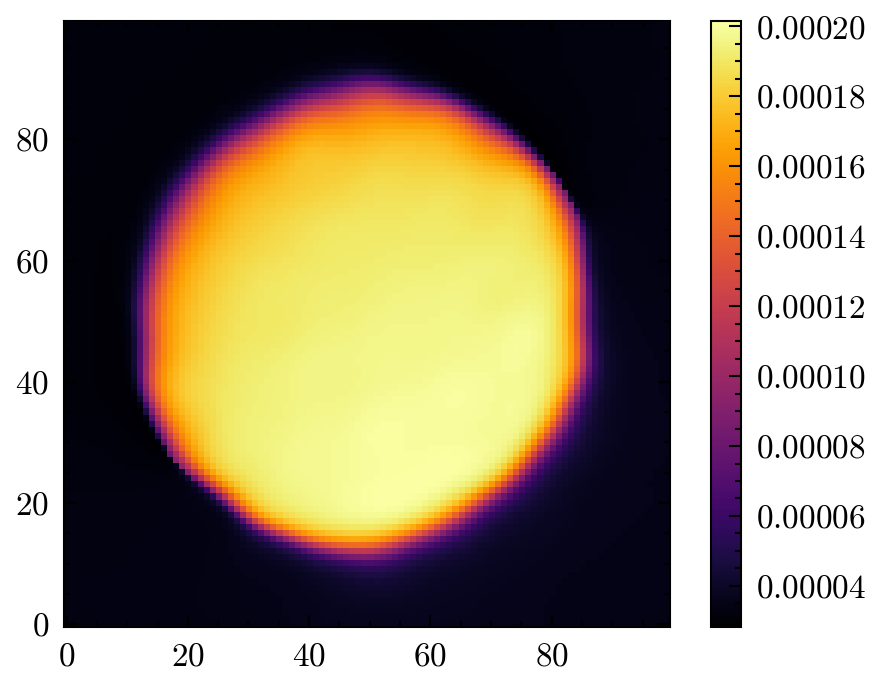

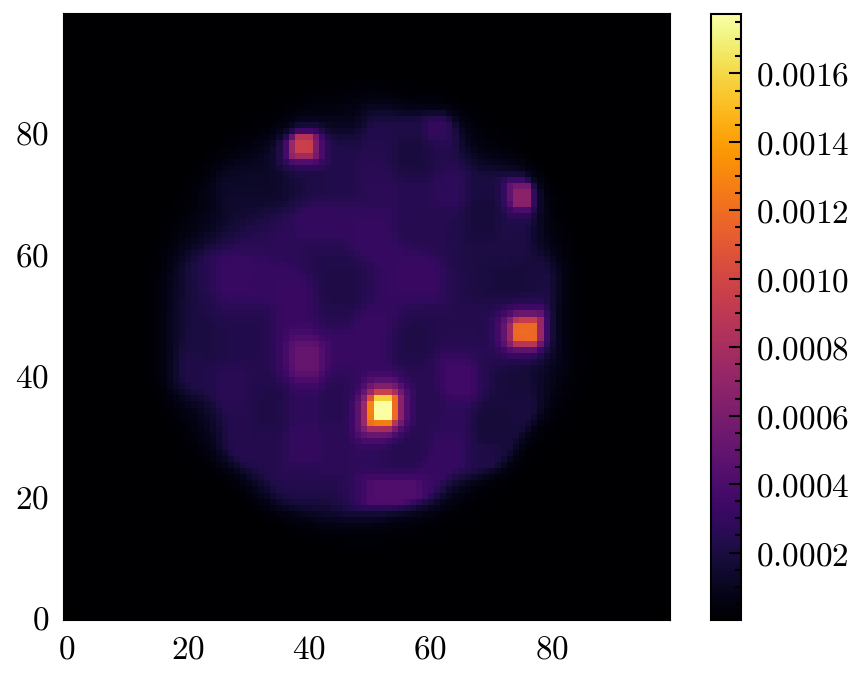

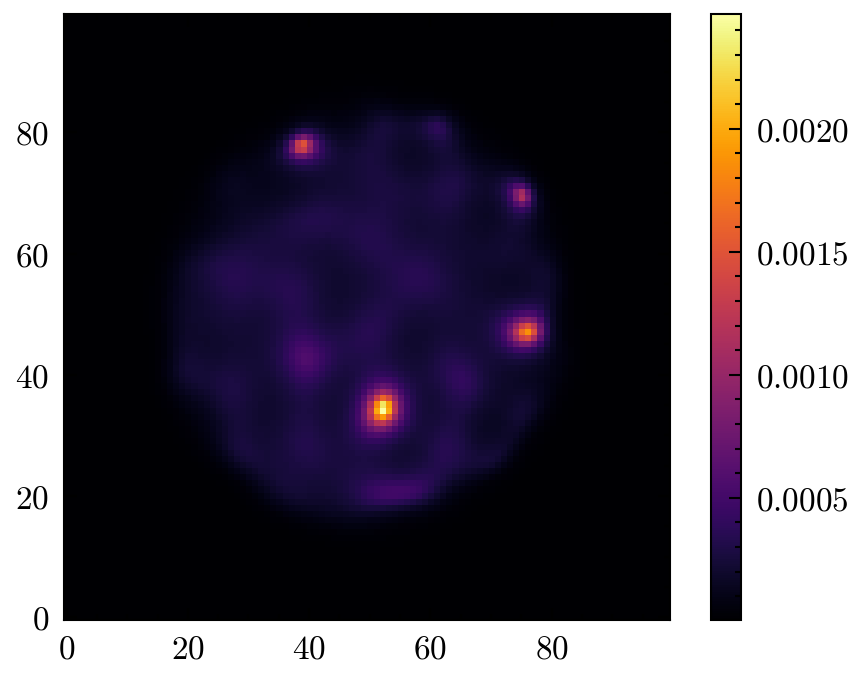

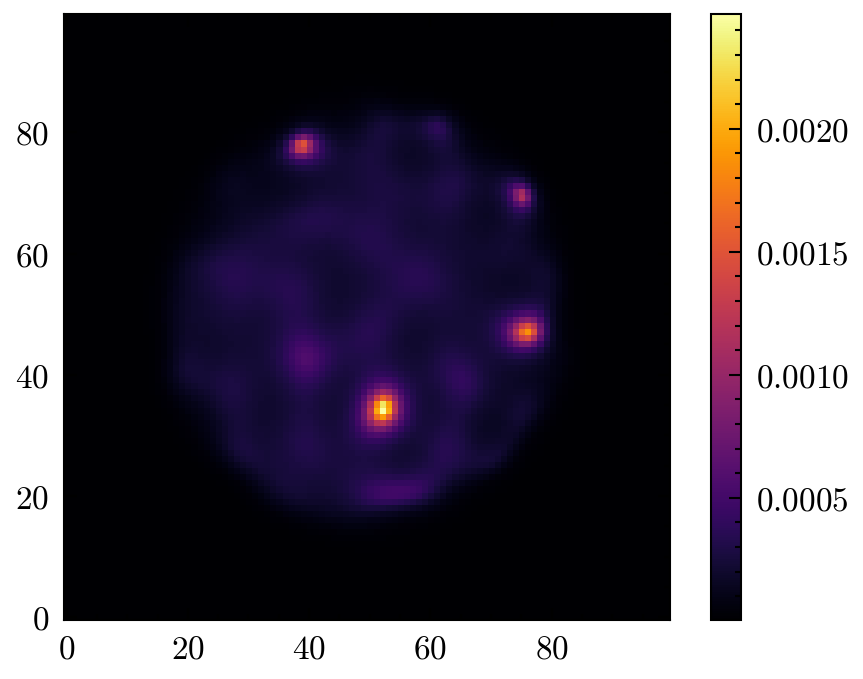

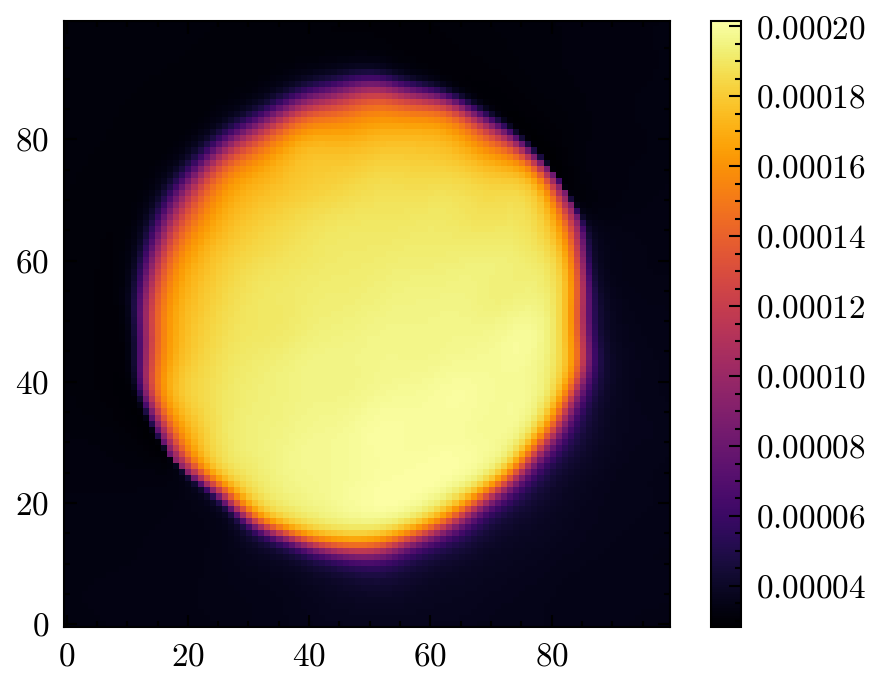

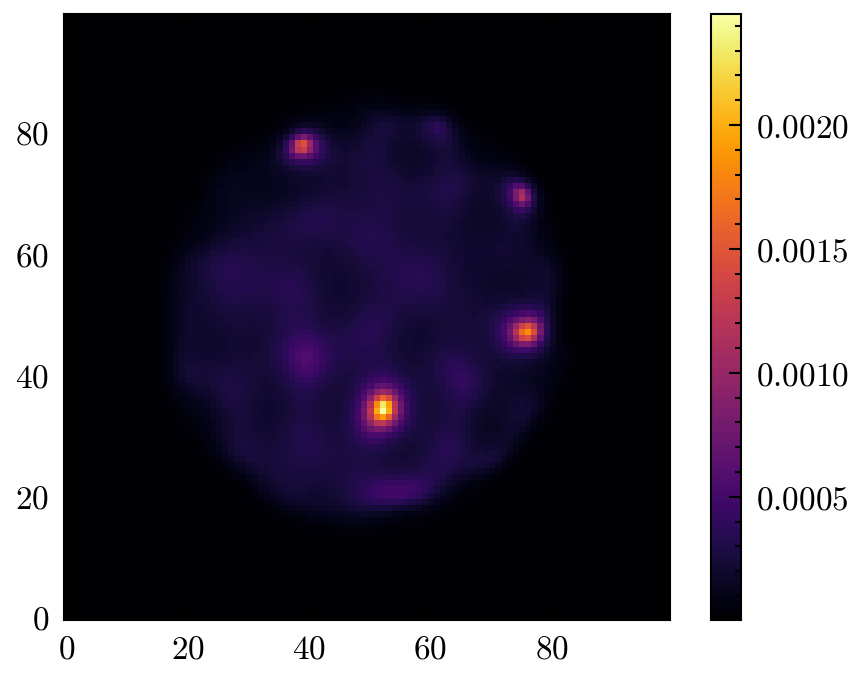

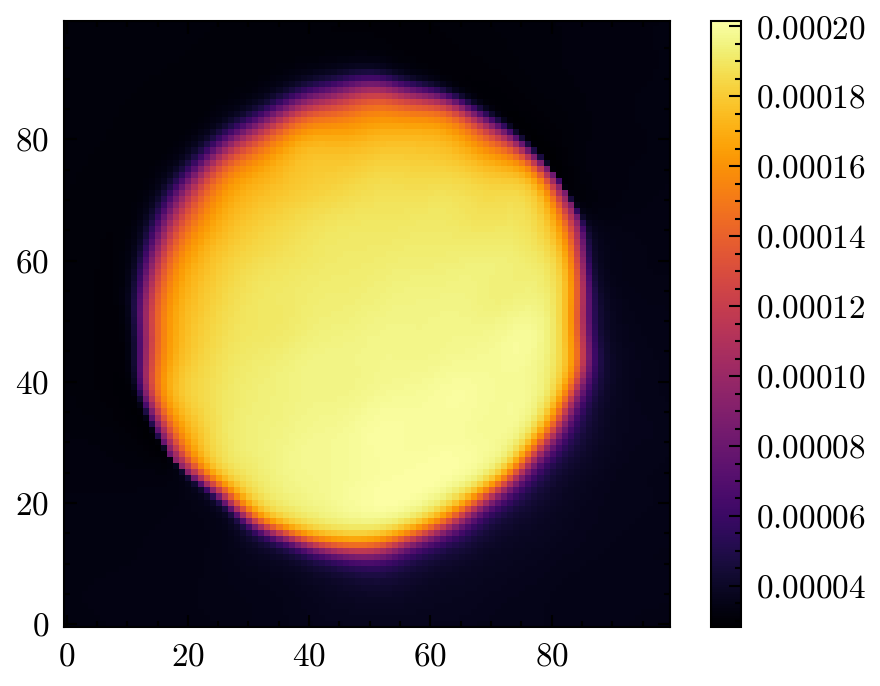

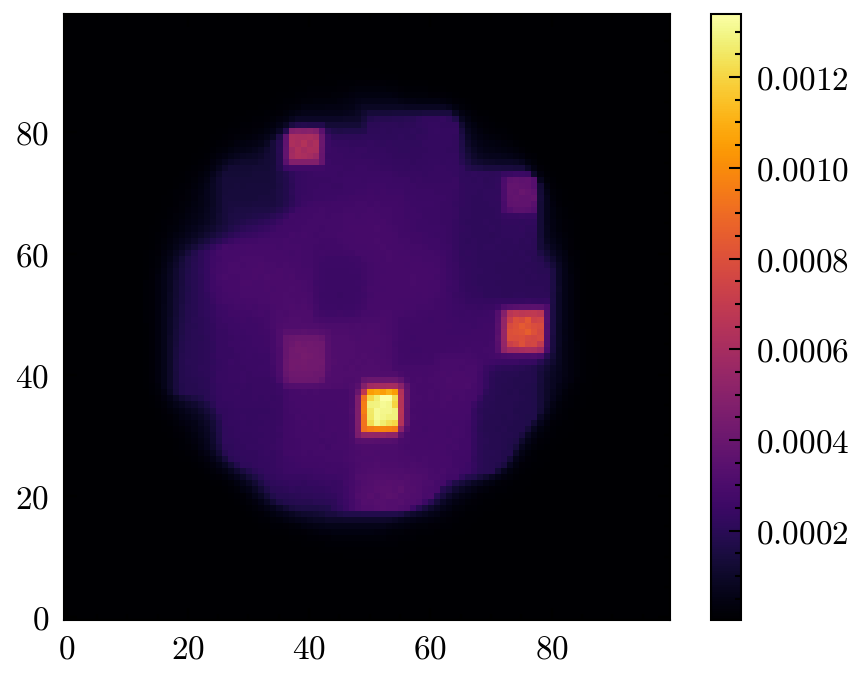

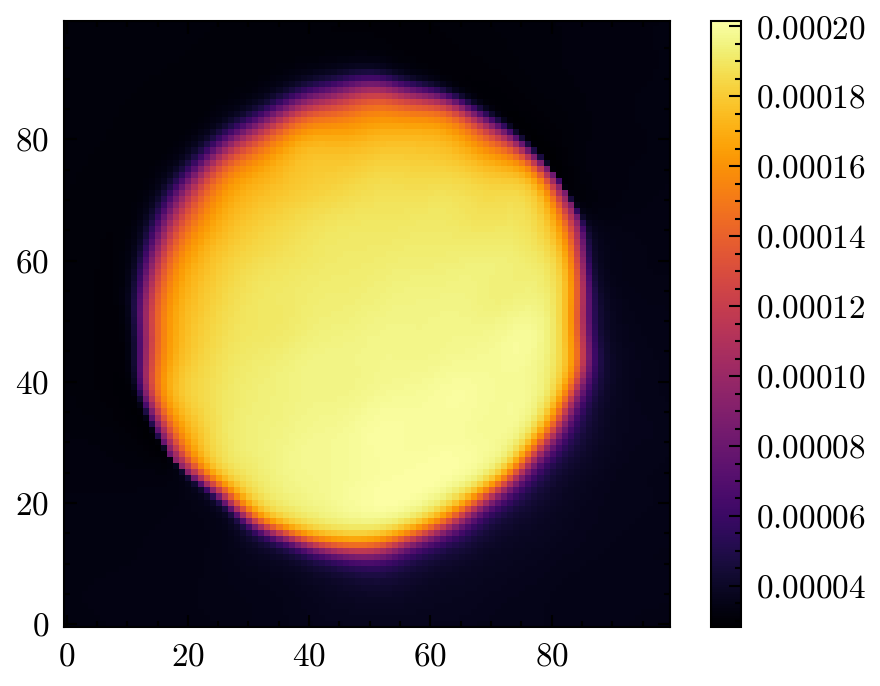

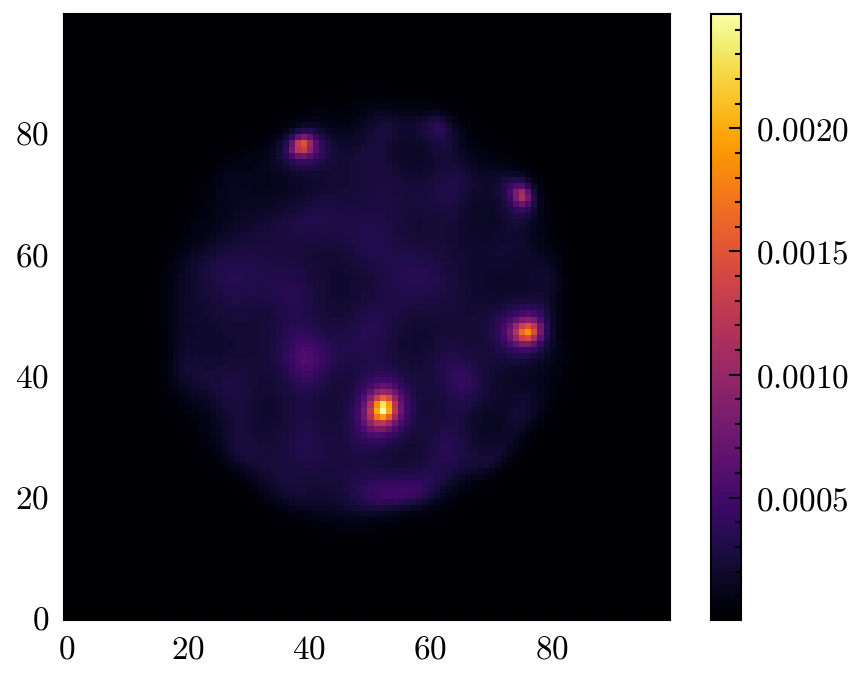

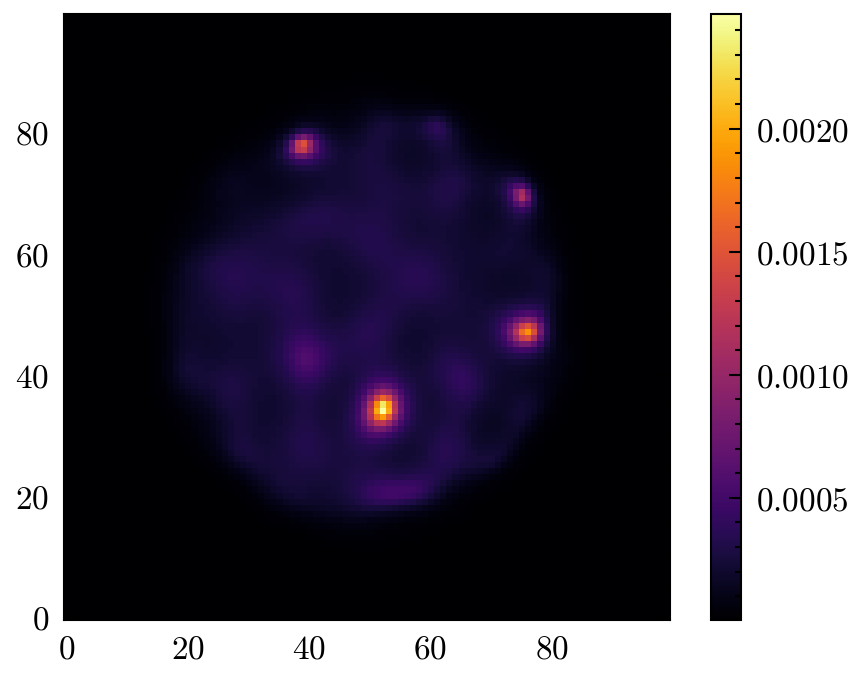

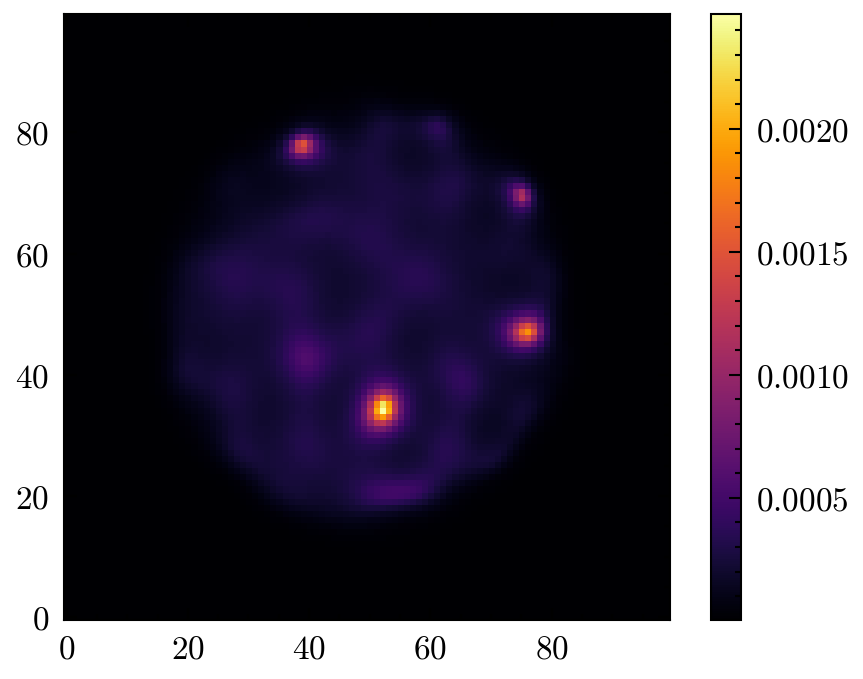

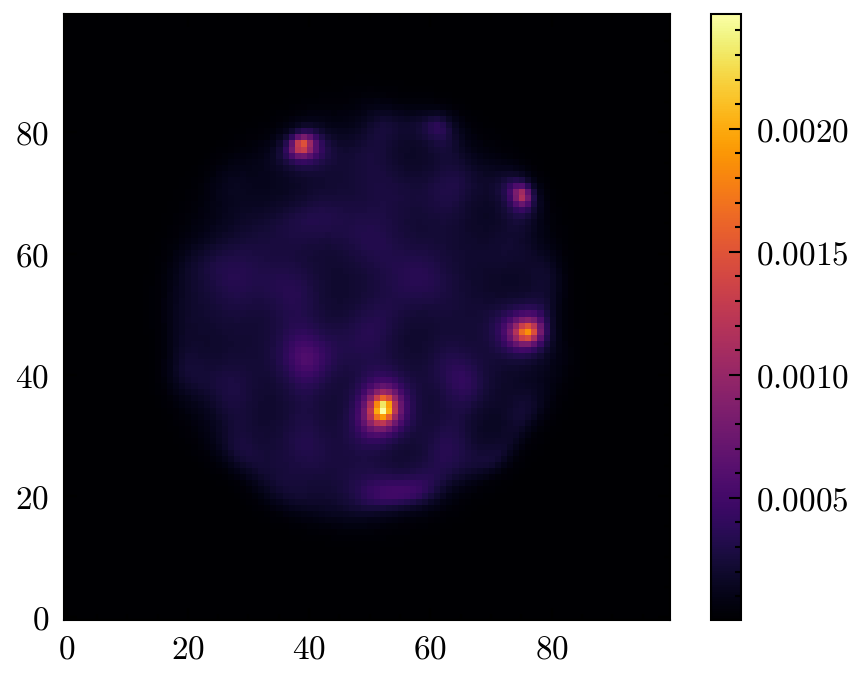

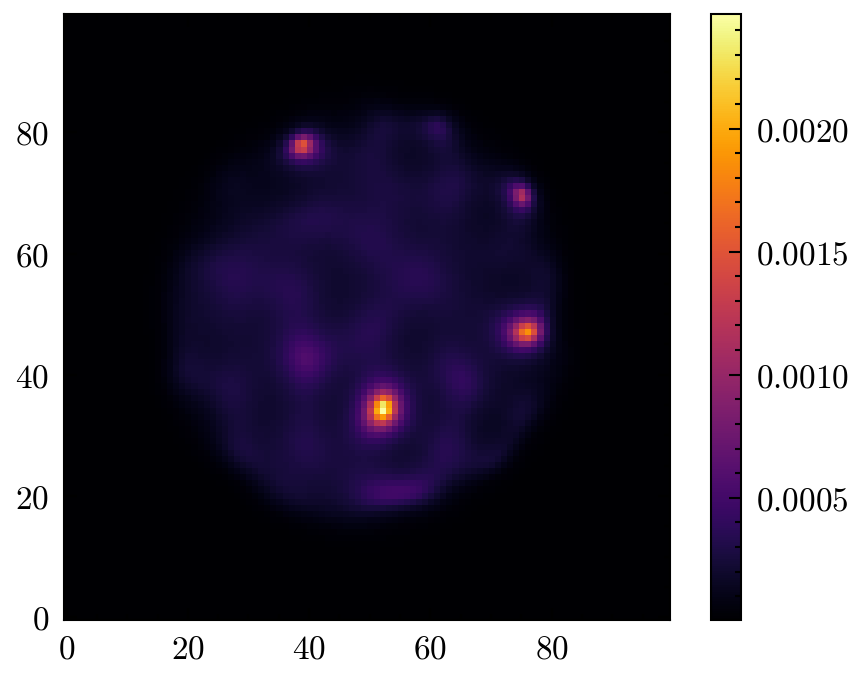

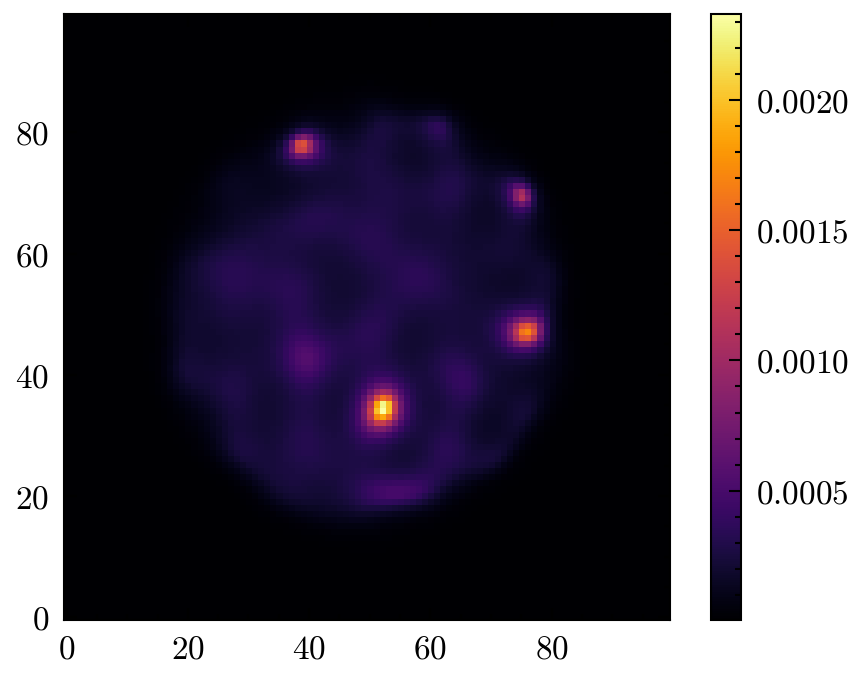

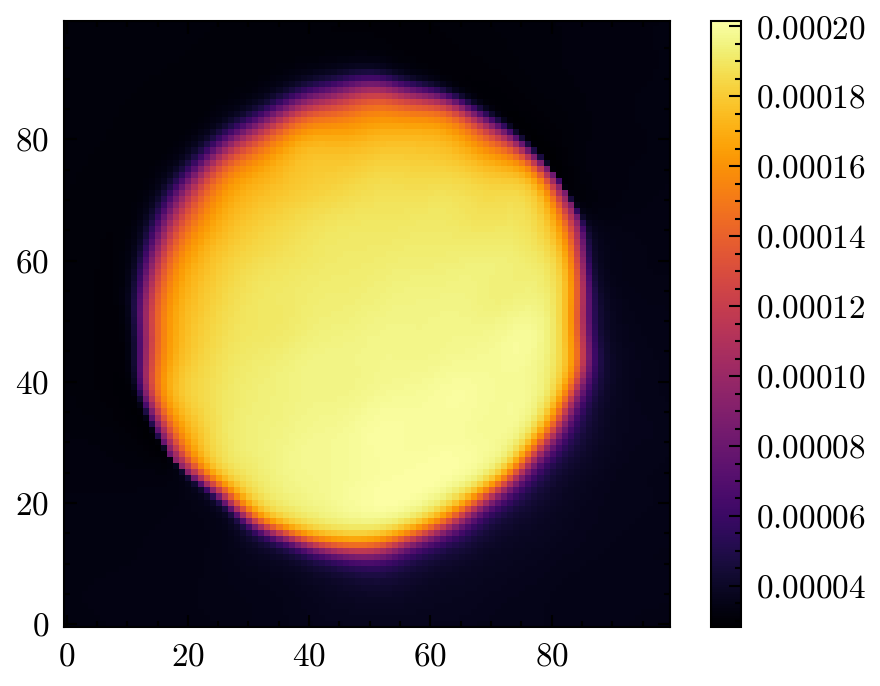

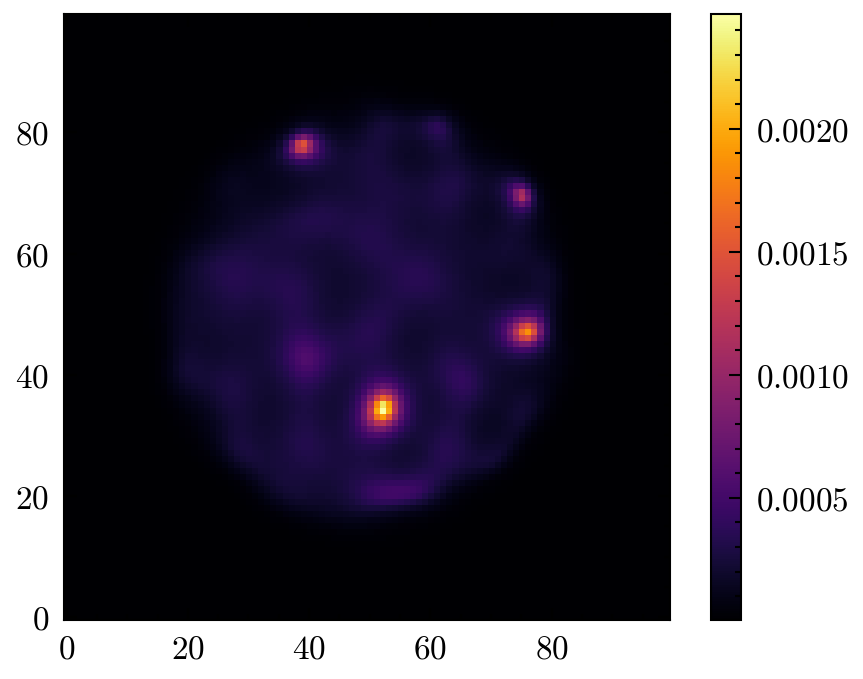

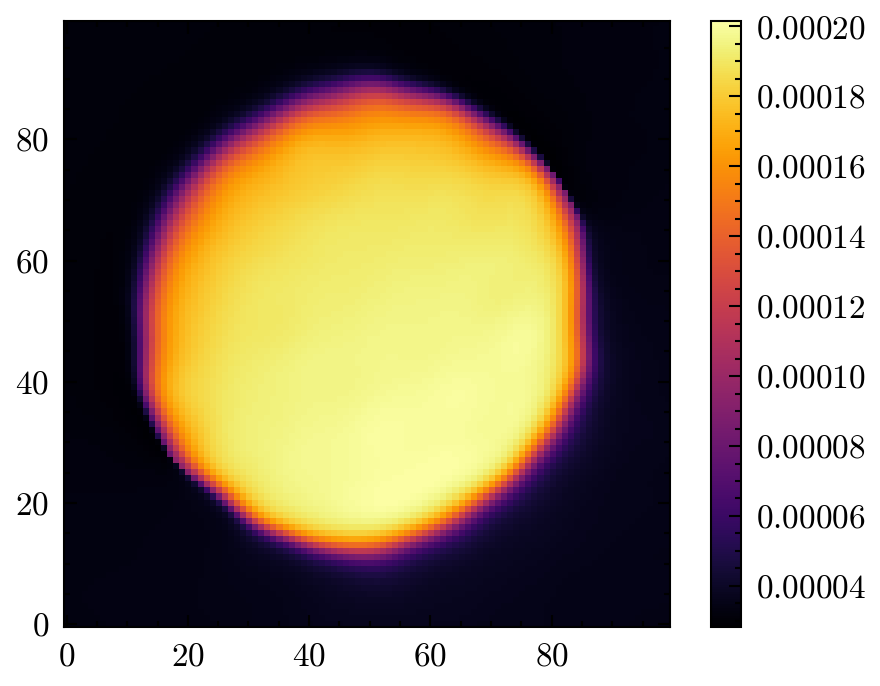

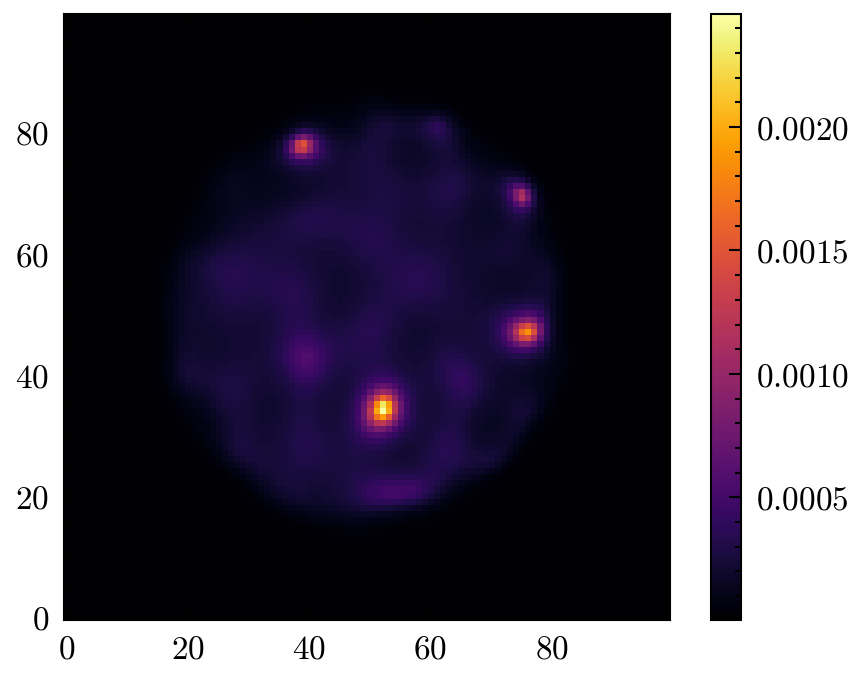

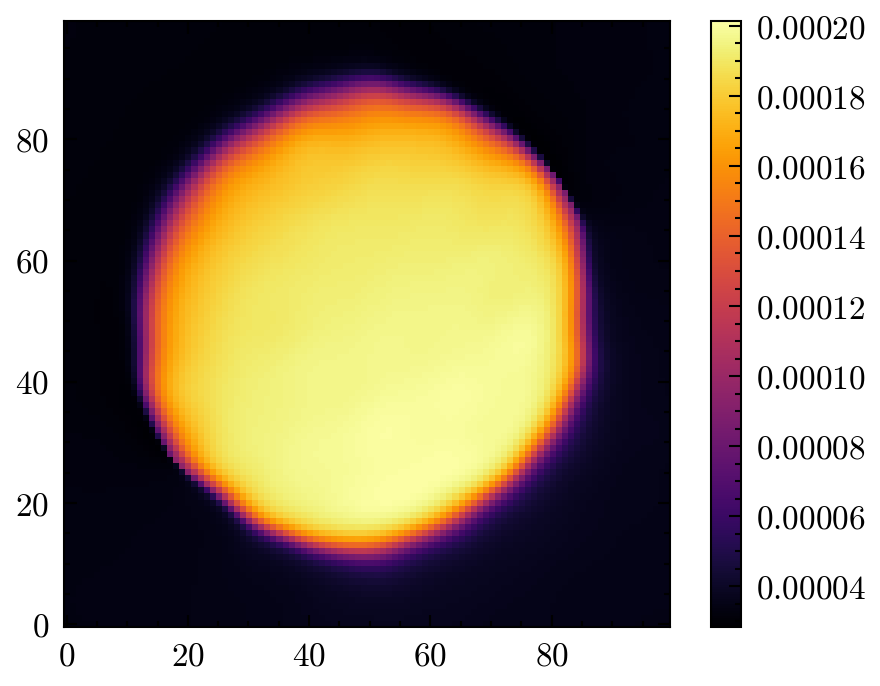

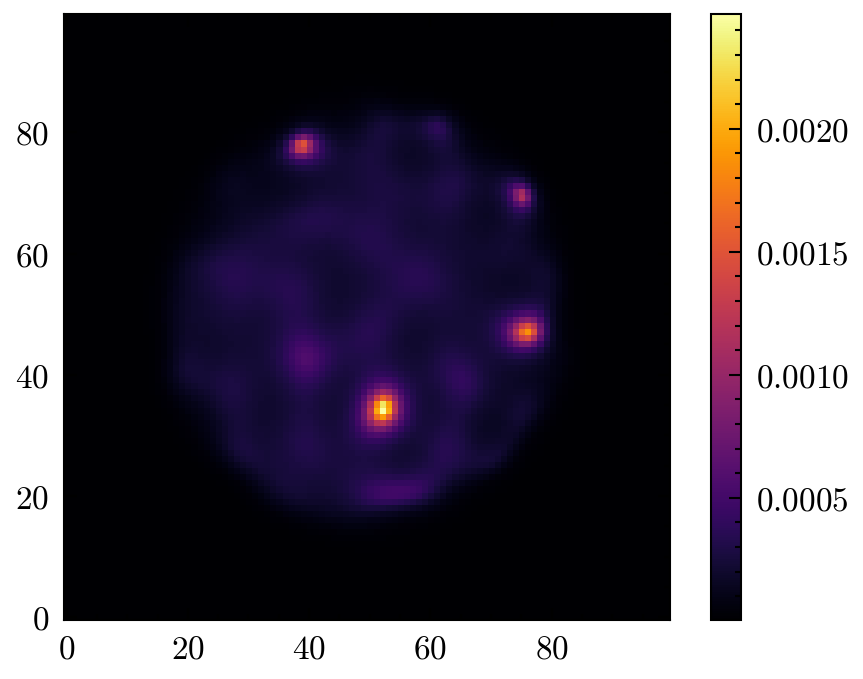

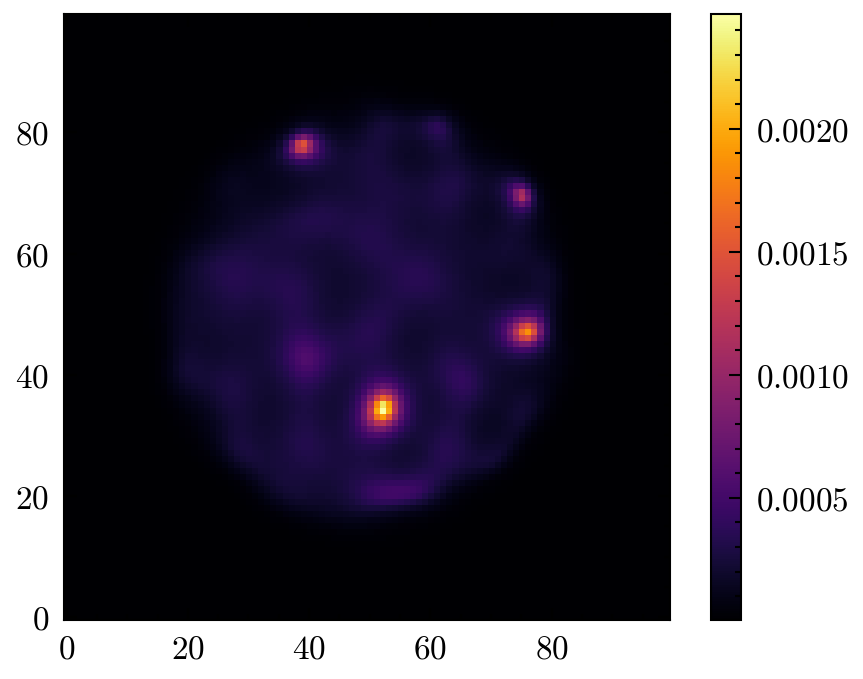

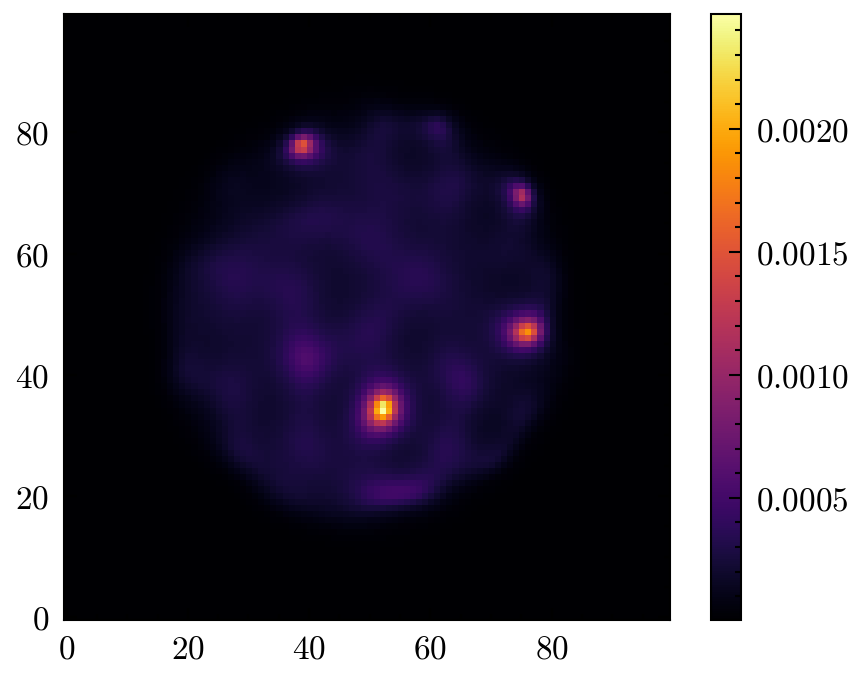

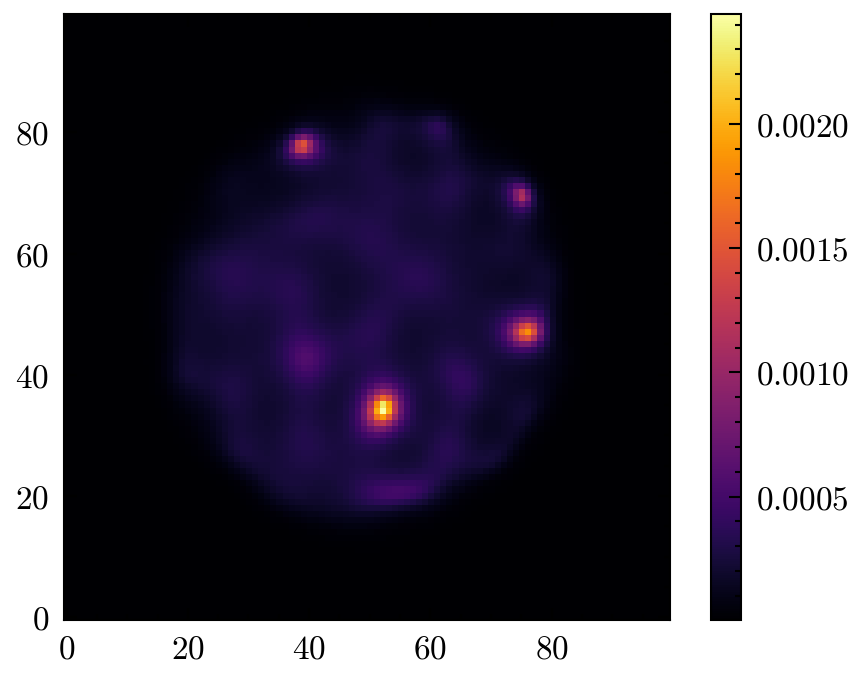

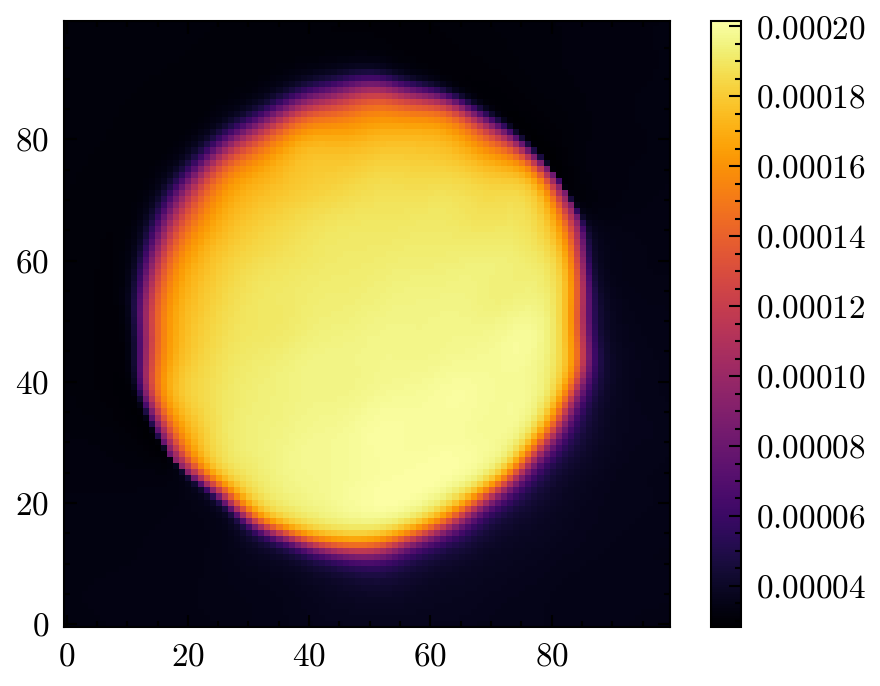

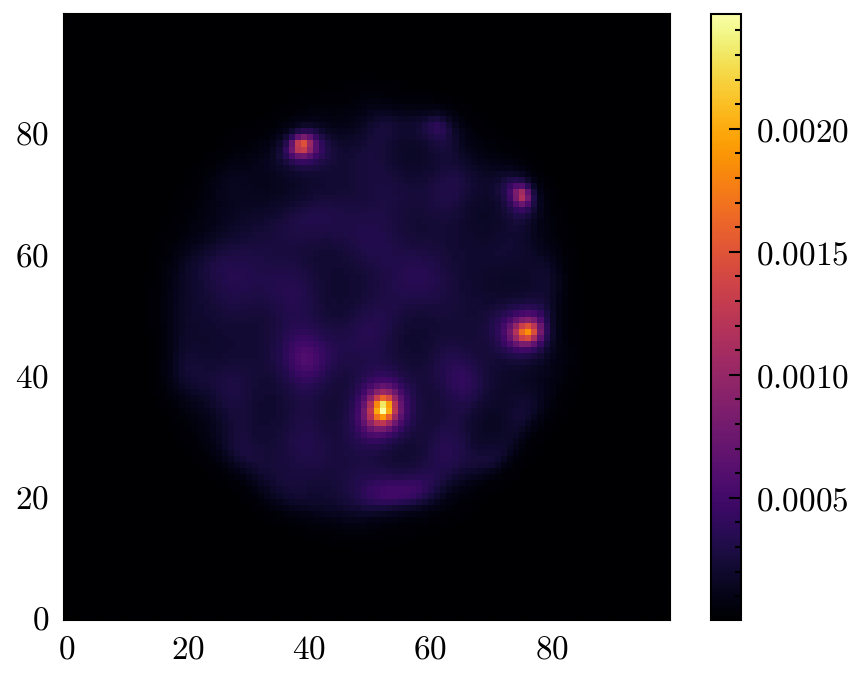

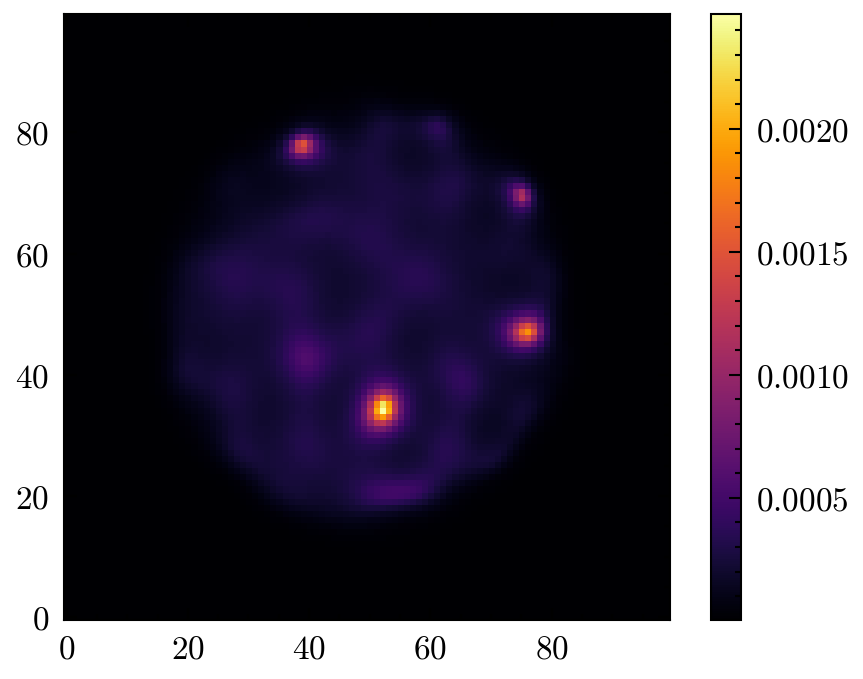

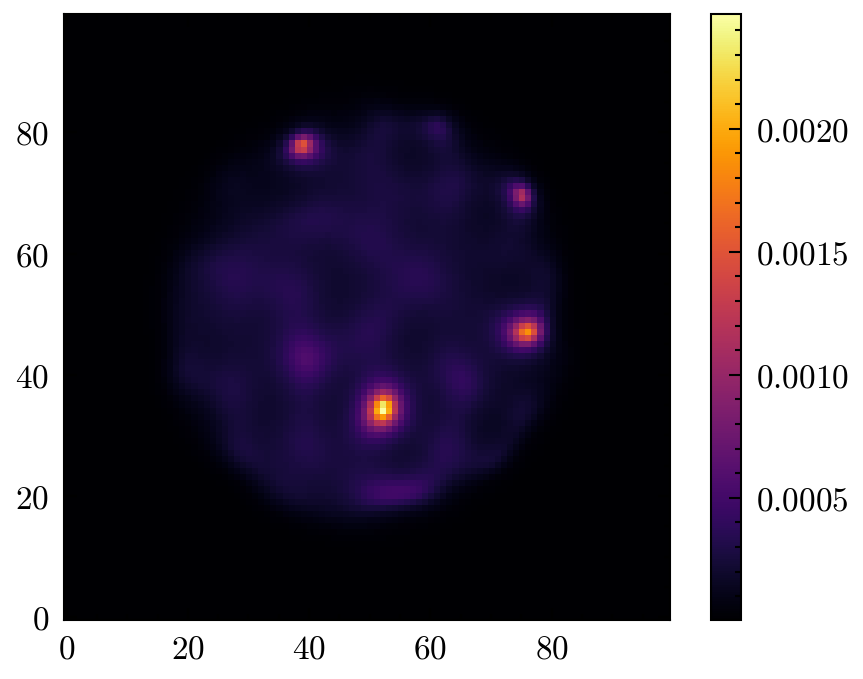

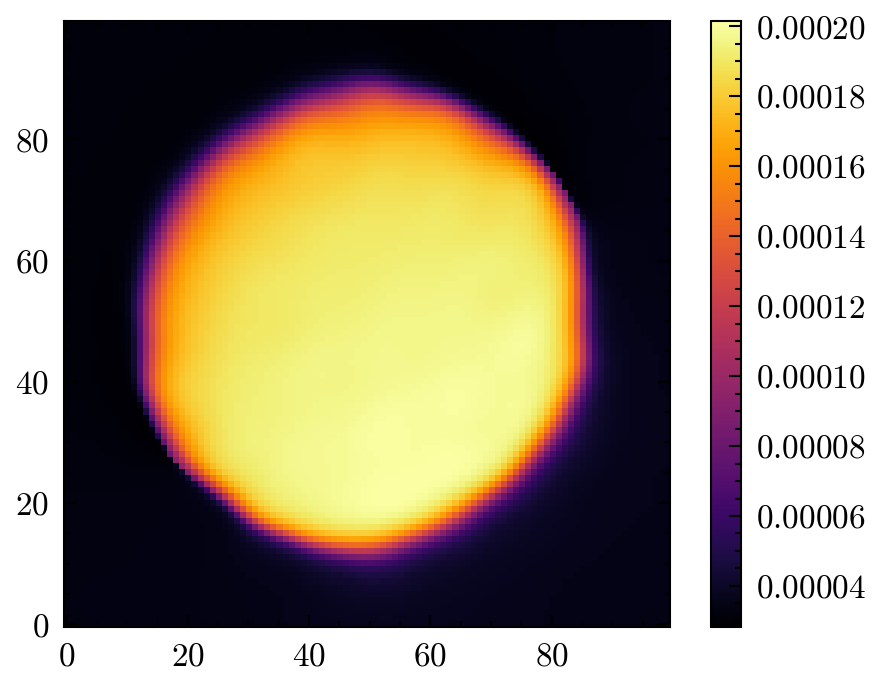

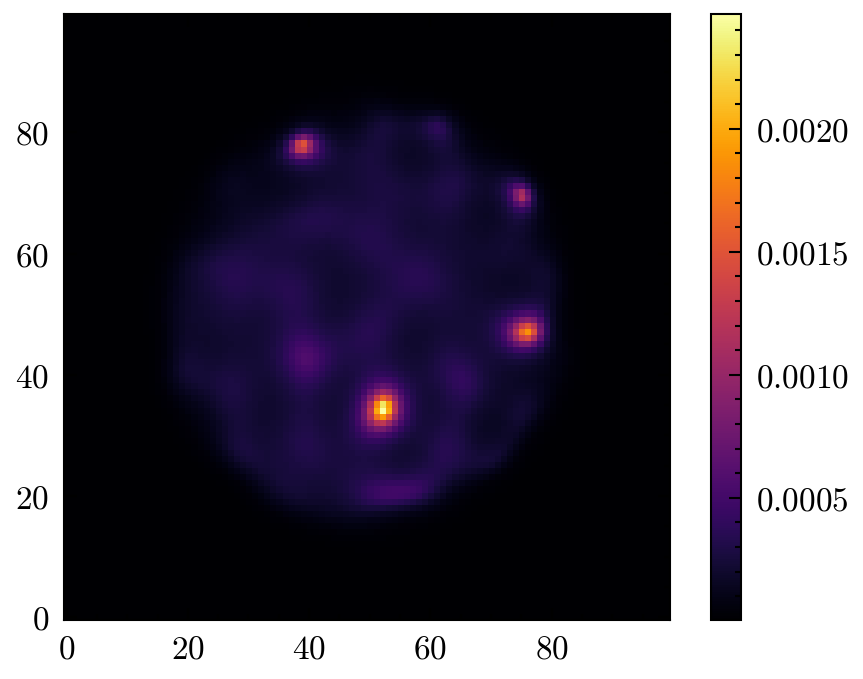

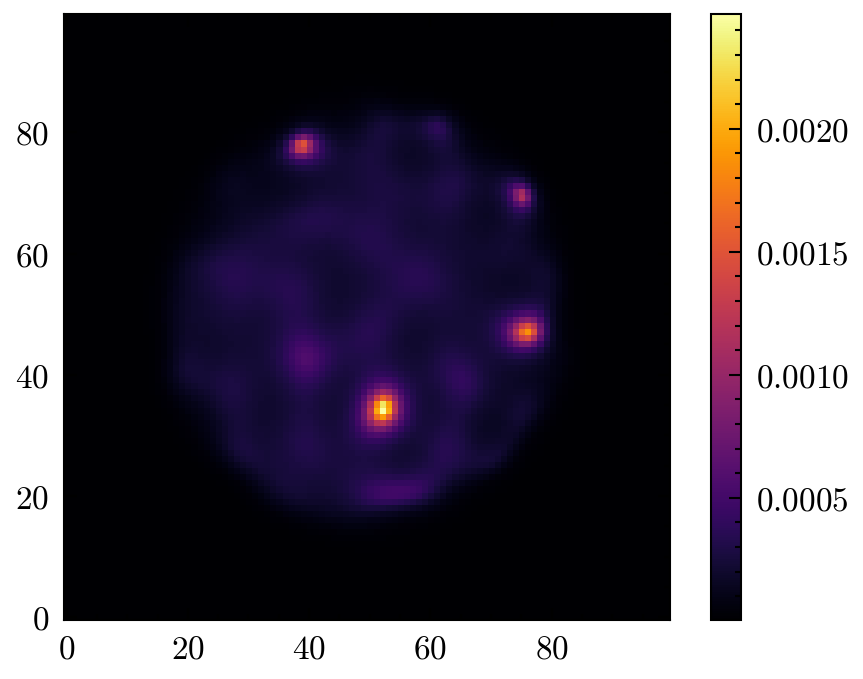

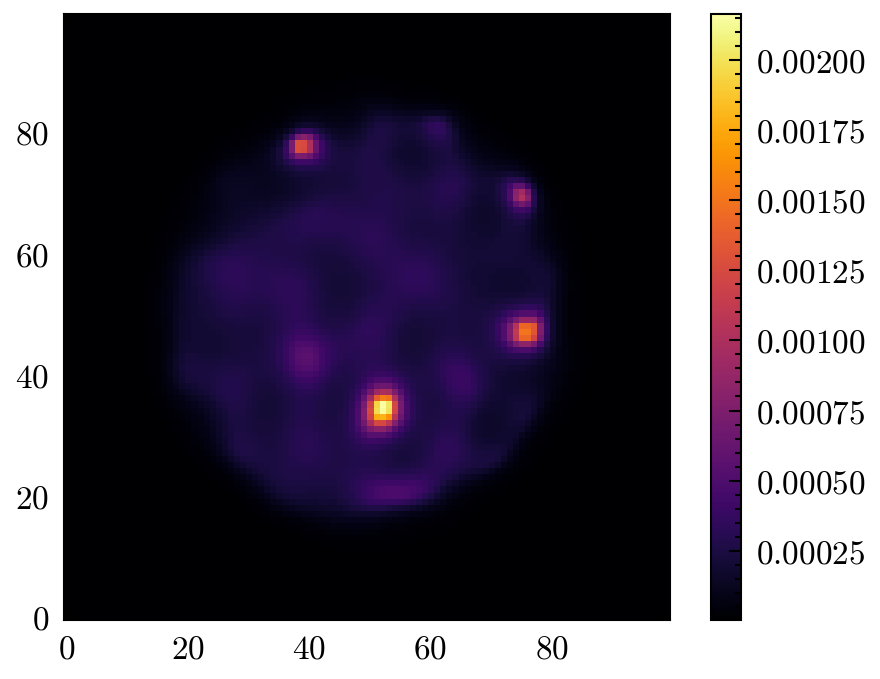

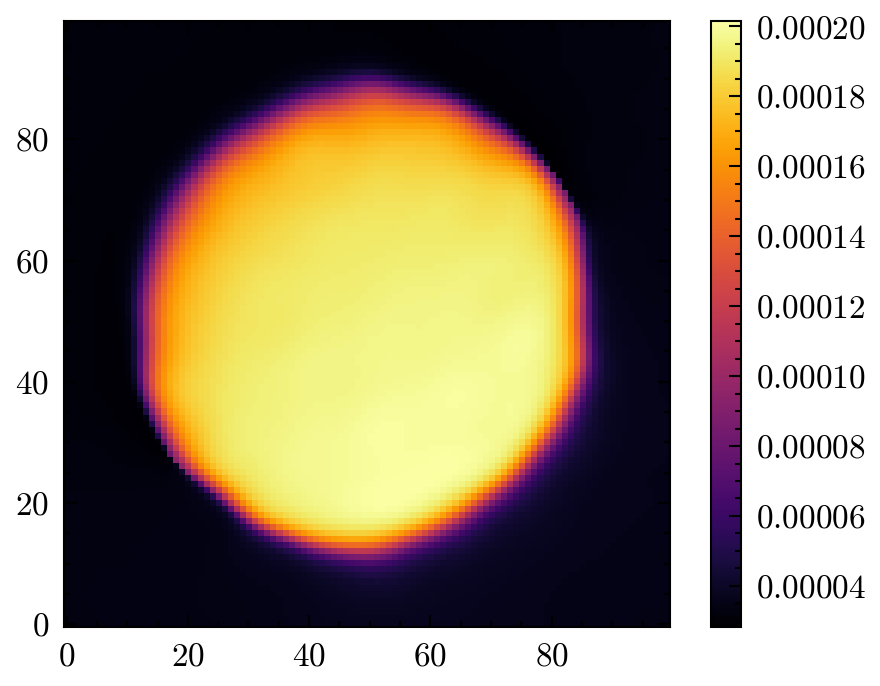

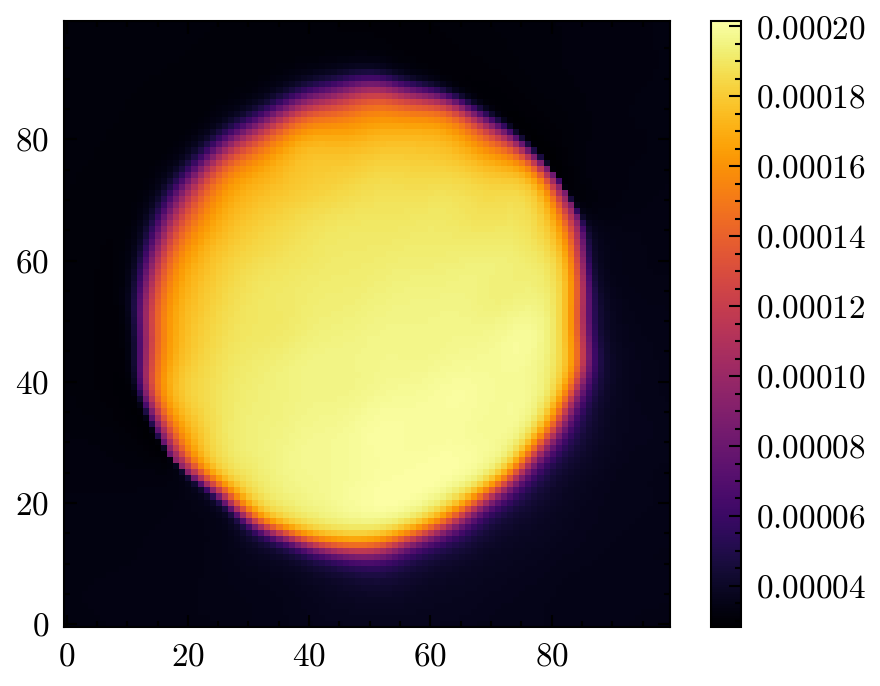

In [18]:
for key, dists in distributions_dict.items():
    plt.figure()
    plt.imshow(dists[0])
    plt.colorbar()
    plt.show()